In [1]:
# import packages
from typing import *
# see this post for cartopy: https://stackoverflow.com/questions/30052990/how-to-use-openstreetmap-background-on-matplotlib-basemap
import cartopy.crs as ccrs  # req add
import cartopy.io.img_tiles as cimgt  # req add

import dload
import geopandas as gpd
import matplotlib.pyplot as plt
import maup
import numpy as np
import os, os.path
import pathlib
import pandas as pd
import pyei
import re
import statsmodels    # req add
import urllib
import zipfile

from pyei.goodmans_er import GoodmansER, GoodmansERBayes


import _toolbox as tools


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/opt/miniconda3/envs/splc_work/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
dir_data = pathlib.Path(os.getcwd()).parents[0]
dir_latex = dir_data.joinpath("report")
dir_figs = dir_latex.joinpath("figures")

if not os.path.exists(dir_figs):
    os.makedirs(str(dir_figs), exist_ok = True, )

In [3]:
# path management
dir_py = pathlib.Path(pathlib.os.getcwd())
dir_data = dir_py.parent.joinpath("data")
if not dir_data.exists():
    dir_data.mkdir()



# Collect Data

In [22]:
##  GET GIT DATA

# init some URL info
url_data = "https://github.com/mggg/rrep/raw/main/rrep_assignment_columbia_ga_files.zip"
ext_url_data = os.path.splitext(url_data)[-1]
dir_base_url_data = os.path.basename(url_data).replace(ext_url_data, "")

# fetch and extract zip
path_extracted = dir_data.joinpath(dir_base_url_data)
if not path_extracted.exists(): # option to skip
    out = urllib.request.urlretrieve(url_data)
    with zipfile.ZipFile(out[0], "r") as file:
        file.extractall(path = dir_data)



##  READ FILES TO DICTS

dict_dfs = {}
dict_shps = {}
loc = "columbia_ga"

def _read_clean(
    keys: List[str],
    ext: str,
    dict_update: dict,
    path: pathlib.Path,
) -> None:
    """
    Update dict_update with data
    """
    if (ext == "csv"):
        func = pd.read_csv 
    elif (ext == "shp"):
        func = gpd.read_file
    else:
        raise RuntimeError(f"Function for extention '{ext}' not defined.")
        
    # load files
    for fl in keys:
        df = func(path.joinpath(f"{loc}_{fl}", f"{loc}_{fl}.{ext}"))
        dict_update.update({fl: df})

    return None


def _read_nested(
    path: pathlib.Path,
    ext: str,
    dict_update: dict,
    dict_key_repl: dict = {},
) -> None:
    """
    Update dict_update with data from a nested file
    """
    if (ext == "csv"):
        func = pd.read_csv 
    elif (ext == "shp"):
        func = gpd.read_file
    else:
        raise RuntimeError(f"Function for extention '{ext}' not defined.")
        
    for fl in os.listdir(path):

        # adjust path if needed
        path_tmp = path
        if (ext in ["csv"]) and not fl.endswith(ext):
                continue
        elif ext in ["shp"]:
            if os.path.extsep in fl:
                continue
                
            path_tmp = path_tmp.joinpath(fl)
            fl = f"{fl}.{ext}"
            
        key = fl.replace(f".{ext}", "")
        for k, v in dict_key_repl.items():
            key = key.replace(k, v)
        df = func(path_tmp.joinpath(fl))
        
        dict_update.update({key: df})

    return None

# read the non-nested files
_read_clean(["pl2020", "turnout", "2022cvap"], "csv", dict_dfs, path_extracted)
_read_clean(["block2020"], "shp", dict_shps, path_extracted)


# read the nested files
_read_nested(
    path_extracted.joinpath(f"{loc}_endogenous_results"), 
    "csv", 
    dict_dfs, 
    dict_key_repl = {"comm": "endogenous"},
)

_read_nested(
    path_extracted.joinpath(f"{loc}_exogenous_results"), 
    "shp", 
    dict_shps, 
    dict_key_repl = {loc: "exogenous"},
)






##  SET SOME FIELDS/KEYS

# general fields
field_choice = "choice"
field_contest = "contest"
field_district = "district_ccbc"
field_geoid = "geoid20"
field_vote_count = "num_votes"
field_precinct = "precinct"

# turnout fields
regex_match = re.compile("(.\D*)(.\d*)_voted_(.\D*$)")
fields_turnout = [
    x for x in dict_dfs.get("turnout").columns 
    if regex_match.match(x) is not None
    and ("gender" not in x)
]






##  IN DFs, CLEAN FIPS

def fips_block(
    x: Any,
    len_code: int = 15,
) -> str:
    out = str(x).rjust(len_code, "0")
    return out
    

# set geoid fields
dict_fields = {
    "2022cvap": "GEOID20",
    "turnout": "geoid20",
    "pl2020": "GEOCODE",
}
# fix FIPS in CVAP, turnout
for df in ["2022cvap", "turnout", "pl2020"]:
    df_cur = dict_dfs.get(df)
    field_cur = dict_fields.get(df)
    if field_cur is None:
        continue

    # rename and clean the field
    
    df_cur[field_cur] = df_cur[field_cur].apply(fips_block)
    df_cur.rename(columns = {field_cur: field_geoid}, inplace = True, )
    dict_dfs.update({df: df_cur})





##  FOR SHPs, SET TO UNIFORM CRS

key_blocks = "block2020"
crs_set = dict_shps.get(key_blocks).crs
crs_set = "EPSG:4326" if crs_set is None else crs_set

for k, v in dict_shps.items():
    dict_shps.update({k: v.to_crs(crs_set)})
    print(f"Shape {k} has CRS {crs_set}")



##  GET SOME DICTIONARIES - START WITH TURNOUT

fp = dir_data.joinpath("rrep_assignment_columbia_ga_files", "columbia_ga_turnout", "README.txt")

def get_turnout_key(
    fp: str,
) -> dict:
    with open(str(fp), "r+") as fl:
        lines_turnout = fl.readlines()


    lines_turnout = [x.split("\t\t") for x in lines_turnout[14:]]
    lines_turnout = dict(
        (x[0].strip(), x[1].strip())
        for x in lines_turnout if len(x) > 1
    )
    
    return lines_turnout

dict_fields_turnout = get_turnout_key(fp)

Shape block2020 has CRS EPSG:4269
Shape exogenous_gen_22 has CRS EPSG:4269
Shape exogenous_gen_20 has CRS EPSG:4269
Shape exogenous_prim_22 has CRS EPSG:4269


In [26]:

# build a uniform df
df_data = (
    pd.merge(
        dict_dfs.get("pl2020"),
        dict_dfs.get("turnout"),
    )
)


fields_data_no_pop = []
for k in df_data.columns:
    if df_data[k].dtype == "object":
        continue

    if df_data[k].sum() == 0:
        fields_data_no_pop.append(k)


# First, look at the demographics of Columbia, GA
- Use 2020 Census, more accurate than 2022 ACS
- Examine demographic distributions
- Compare CVAP
- Explore choropleths of population for geospatial distribution

In [28]:
# some regular expressions
dict_ind_to_description = {
    1: "race",
    2: "ethn",
    3: "race_geq18",
    4: "ethn_geq18",
    5: "grpq",
}

def build_pl94_fields_dict(
    df: pd.DataFrame,
    dict_ind_to_description: dict,
) -> dict:
    """
    Build a dictionary mapping demographic PL94 fields to fields in df; returns
        a dictionary whose keys are the values in dict_ind_to_description; values 
        map to dictionaries including the regular matching expression ("regex") 
        and fields that match ("fields")
    """
    dict_dem_fields = {}
    
    for k, v in dict_ind_to_description.items():
    
        # get regular expression
        regex = re.compile(f"P00{k}(.\d*$)")
        dict_cur = {"regex": regex, }
    
        fields = [x for x in df.columns if regex.match(x) is not None]
        dict_cur.update({"fields": fields})
        
        dict_dem_fields.update({v: dict_cur})


    return dict_dem_fields

dict_pl94_fields_df_data = build_pl94_fields_dict(
    df_data, 
    dict_ind_to_description,
)

In [29]:
# field subset function -- use codes https://redistrictingdatahub.org/data/about-our-data/pl-94171-dataset/fields-and-descriptions/
def f(
    i: int, 
    grp: int
):
    out = str(i).rjust(2, "0")
    out = f"P00{grp}00{out}"
    return out
    
fields_race = [f(i, 1) for i in range(3, 10)]
fields_ethn = [f(i, 2) for i in range(2, 4)]
fields_race_geq18 = [f(i, 3) for i in range(3, 10)]
fields_ethn_geq18 = [f(i, 4) for i in range(2, 4)]
fields_grpq = [f(i, 5) for i in [3, 4, 5, 6, 8, 9, 10]]

fields_demo = (
    fields_race
    + fields_ethn
    + fields_race_geq18
    + fields_ethn_geq18
    + fields_grpq
)


# totals by PL94; note
def disp_and_add(
    flds: List[str],
    note: str,
    add: bool = True,
    disp: bool = True,
    df: pd.DataFrame = df_data,
) -> None:
    """
    Show some fractions by breakdown and add fractional data to df
    """
  
    pops = df[flds].sum()
    tot = pops.sum().astype(int)
    pops_norm = pops/pops.sum() # weights by racial category

    if disp:
        print(f"{note}:\nTotal pop:\t{tot}\nFractions:\n{pops_norm}\n")

    if add:
        fields_new = [f"frac_{x}" for x in flds]

        tots = (
            df[flds]
            .sum(axis = 1)
            .to_numpy()
        )
        arr_new = (
            df[flds]
            .to_numpy()
            .transpose()
        )
        arr_new = np.nan_to_num(
            (arr_new/tots).transpose(),
            0.0,
            posinf = 0.0
        )

        df[fields_new] = arr_new
        
    return None



# prep df_data by dropping 0 pop fields (that aren't in the demographic groups defined here)
df_data.drop(
    columns = [
        x for x in df_data.columns 
        if (x in fields_data_no_pop)
        & (x not in fields_demo + fields_turnout)
        
    ], 
    inplace = True, 
)

disp_and_add(fields_race, "By race")
disp_and_add(fields_ethn, "By ethnicity")
disp_and_add(fields_race_geq18, "By race (>= 18)")
disp_and_add(fields_ethn_geq18, "By ethnicity (>= 18)")
disp_and_add(fields_grpq, "By group quarters")

# set some fields
fields_demographic = fields_race + [f"frac_{x}" for x in fields_race]
fields_demographic += fields_ethn + [f"frac_{x}" for x in fields_ethn]
fields_demographic += fields_race_geq18 + [f"frac_{x}" for x in fields_race_geq18]
fields_demographic += fields_ethn_geq18 + [f"frac_{x}" for x in fields_ethn_geq18]


By race:
Total pop:	156010
Fractions:
P0010003    0.653984
P0010004    0.181495
P0010005    0.003461
P0010006    0.046221
P0010007    0.001936
P0010008    0.025107
P0010009    0.087796
dtype: float64

By ethnicity:
Total pop:	156010
Fractions:
P0020002    0.076008
P0020003    0.923992
dtype: float64

By race (>= 18):
Total pop:	114823
Fractions:
P0030003    0.677086
P0030004    0.177970
P0030005    0.003588
P0030006    0.048466
P0030007    0.001690
P0030008    0.023035
P0030009    0.068166
dtype: float64

By ethnicity (>= 18):
Total pop:	114823
Fractions:
P0040002    0.064055
P0040003    0.935945
dtype: float64

By group quarters:
Total pop:	1223
Fractions:
P0050003    0.185609
P0050004    0.000000
P0050005    0.635323
P0050006    0.000000
P0050008    0.000000
P0050009    0.000000
P0050010    0.179068
dtype: float64



/var/folders/rv/0qtmbvjn78z0db_b7kvpp2600000gp/T/ipykernel_1348/3299938700.py:58: RuntimeWarning: invalid value encountered in divide
  (arr_new/tots).transpose(),
/var/folders/rv/0qtmbvjn78z0db_b7kvpp2600000gp/T/ipykernel_1348/3299938700.py:58: RuntimeWarning: invalid value encountered in divide
  (arr_new/tots).transpose(),
/var/folders/rv/0qtmbvjn78z0db_b7kvpp2600000gp/T/ipykernel_1348/3299938700.py:58: RuntimeWarning: invalid value encountered in divide
  (arr_new/tots).transpose(),
/var/folders/rv/0qtmbvjn78z0db_b7kvpp2600000gp/T/ipykernel_1348/3299938700.py:58: RuntimeWarning: invalid value encountered in divide
  (arr_new/tots).transpose(),
/var/folders/rv/0qtmbvjn78z0db_b7kvpp2600000gp/T/ipykernel_1348/3299938700.py:58: RuntimeWarning: invalid value encountered in divide
  (arr_new/tots).transpose(),


In [ ]:


# Bounds: (lon_min, lon_max, lat_min, lat_max):
extent = [1, 13, 45, 53]

ax = pl.axes(projection=request.crs)
ax.set_extent(extent)
ax.add_image(request, 5) 

In [355]:
def get_osm_extent_from_gdf(
    gdf: gpd.GeoDataFrame,
    factor: float = 0.05,
) -> List[float]:
    """
    Retrieve a list of plot extents to use in for OSM background
    """

    # get an OSM set of bounds
    bounds_base = gdf.geometry.total_bounds
    
    x_min, y_min, x_max, y_max = bounds_base

    extent = [
        x_min - (x_max - x_min)*factor, # lon min
        x_max + (x_max - x_min)*factor, # lon max
        y_min - (y_max - y_min)*factor, # lat min
        y_max + (y_max - y_min)*factor, # lat max
    ]

    return extent

extent = get_osm_extent_from_gdf(
    dict_shps.get(keys[0]),
)

request = cimgt.OSM()

In [444]:
import contextily as cx

# Take a look at the shapefiles we have


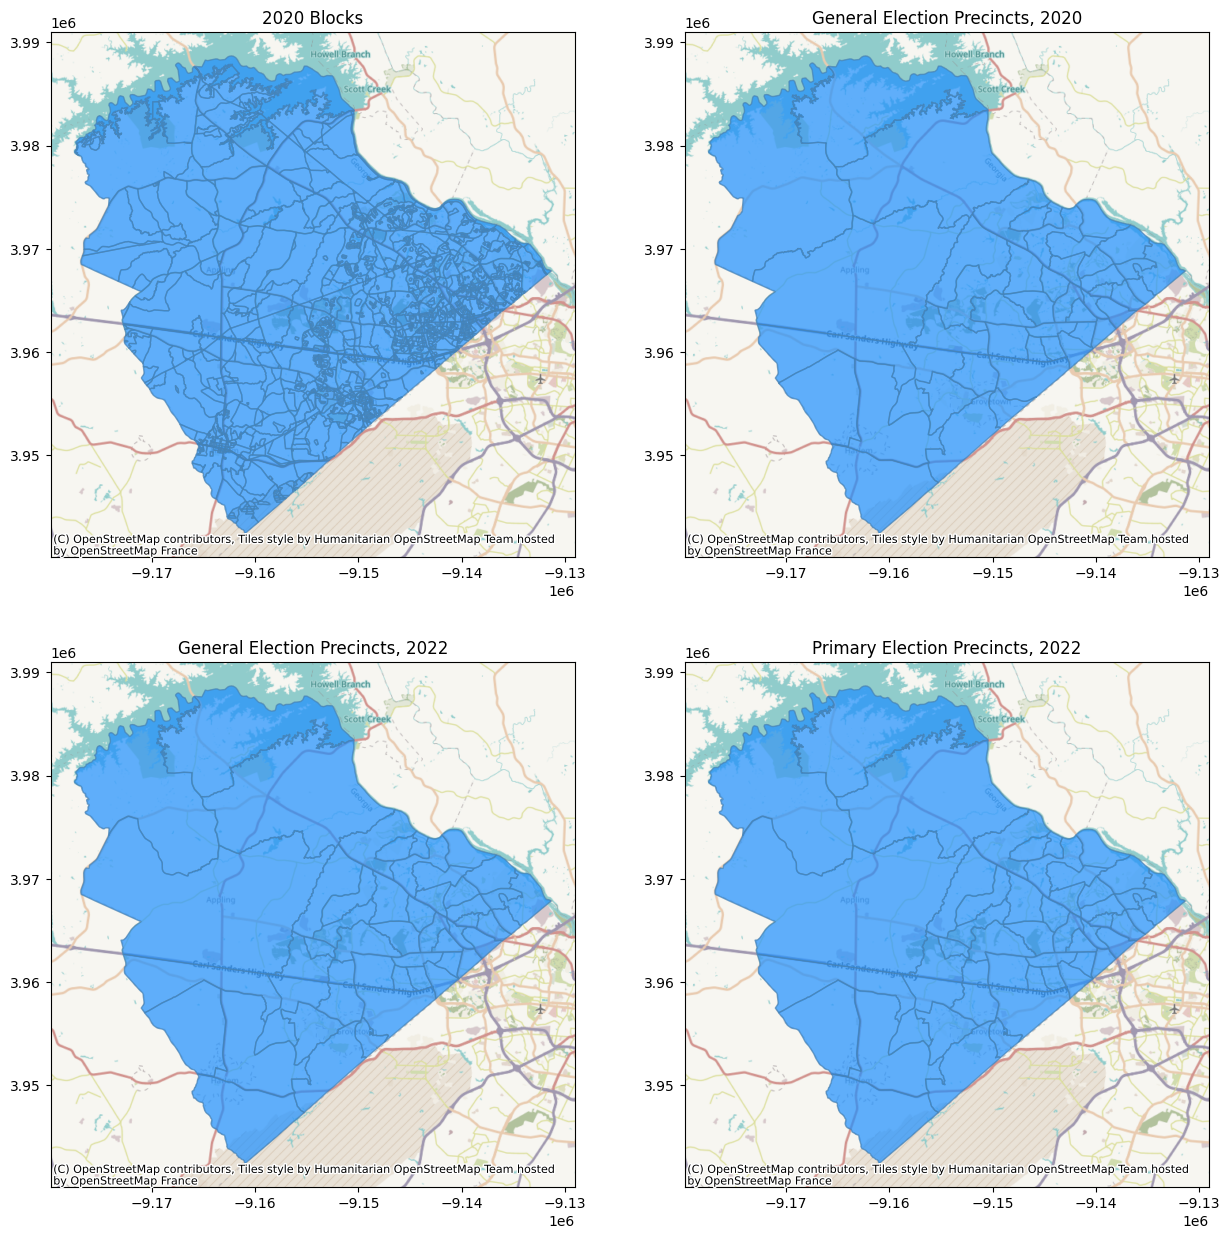

In [463]:
keys = sorted(list(dict_shps.keys()))

fig, ax = plt.subplots(2, 2, figsize = (15, 15))

dict_precinct_names = {
    "block2020": "2020 Blocks",
    "exogenous_gen_20": "General Election Precincts, 2020",
    "exogenous_gen_22": "General Election Precincts, 2022",
    "exogenous_prim_22": "Primary Election Precincts, 2022"
}

#ax = plt.axes(projection=request.crs)
#ax.set_extent(extent)
#ax.add_image(request, 10)


for k, key in enumerate(keys):

    # get axis point
    j = k%2
    i = int((k - j)/2)

    # add to plot
    gdf_plot = (
        dict_shps
        .get(key)
        .copy()
        .to_crs(epsg = 3857)
    )# convert to web mercator
    (
        gdf_plot
        .plot(
            alpha = 0.7,
            edgecolor = "steelblue",
            color = "dodgerblue",
            ax = ax[i, j],
        )
    )

    # add some info
    title = dict_precinct_names.get(key)
    
    ax[i, j].set_title(title)
    cx.add_basemap(ax[i, j])


plt.savefig(
    dir_figs.joinpath("geodata_panel.png"),
    dpi = 200,
    bbox_inches = "tight",
)
    
    

# Assign blocks to different geospatial overlays (exogenous election precincts)

In [32]:
import warnings
warnings.filterwarnings("ignore")

def field_assignment(
    nm: str,
    inv: bool = False,
) -> str:
    """
    Assignment field mapping base tile (block) to MAUP assigned overlay
    """
    prep = "assignment_"
    out = (
        f"{prep}{nm}"
        if not inv
        else nm.replace(prep, "")
    )

    return out



    
# build assignments for blocks to precincts
gdf_block = dict_shps.get(key_blocks)
gdf_block.rename(
    columns = {"GEOID20": field_geoid},
    inplace = True,
)
# build a crosswalk from GEOID to precinct
#df_block_to_precincts = pd.DataFrame(gdf_block[[field_geoid]], )

for k, v in dict_shps.items():
    if k == key_blocks:
        continue

    # make some adjustments
    if "PRECINCT_N" in v.columns:
        v.rename(
            columns = {"PRECINCT_N": field_precinct},
            inplace = True,
        )
        

    vec_assignment_index = maup.assign(gdf_block, v)

    vec_precincts = v[field_precinct].to_numpy()
    vec_precincts = [
        (vec_precincts[int(x)] if not np.isnan(x) else None) 
        for x in vec_assignment_index
    ]

    gdf_block[field_assignment(k)] = vec_precincts
    # 
    #df_block_to_precincts = pd.merge(
    #    df_block_to_precincts,
    #    gdf_block[[field_geoid, field_assignment(k)]]
    #)

dict_shps.update({key_blocks: gdf_block})



##  District maps for Columbia County Commission in Georgia are not downloadable, so we will recreate here

In [364]:
contests_ignore = ["County Commission Chairperson"]

df_precinct_to_district = (
    pd.concat(
        [
            dict_dfs.get("endogenous_gen_20"),
            dict_dfs.get("endogenous_gen_22")
        ]
    ) 
    .get(
        [
            field_contest,
            field_precinct,
            field_vote_count,
        ]
    )
    .groupby(
        [
            field_contest,
            field_precinct
        ]
    )
    .sum()
    .reset_index()
)

# drop out contests we don't
df_precinct_to_district = (
    df_precinct_to_district[
        ~df_precinct_to_district[field_contest].isin(contests_ignore)
    ]
    .reset_index(drop = True)
)


##  Next, group by precinct and select the const associated with most recent election
# - note: this should only affect 
#         - Martinez Baptist
#         - Riverview Church
# -  

# get set of contests in most recent elections
contests_most_recent = dict_dfs.get("endogenous_gen_22")[field_contest].unique()

# check if uniquely assigned
dfg = df_precinct_to_district.groupby([field_precinct])
df_precinct_to_district_out = []

# 
for pr, df in dfg:
    if len(df) > 1:
        df = df[
            df[field_contest]
            .isin(contests_most_recent)
        ] 

    df_precinct_to_district_out.append(df.reset_index(drop = True))


# concat and clean the district names
df_precinct_to_district_out = (
    pd.concat(df_precinct_to_district_out)
    .sort_values(by = [field_contest, field_precinct])
    .reset_index(drop = True)
)

df_precinct_to_district_out[field_district] = [
    int(
        x
        .replace(" - ", " ")
        .replace("County Commission District ", "")
    ) for x in list(df_precinct_to_district_out[field_contest])
]



# get precincts from shapefile
all_precincts_2022 = (
    dict_shps
    .get(key_blocks)[
        field_assignment("exogenous_gen_22")
    ]
    .unique()
)

"""
# some manual overwrites
dict_replace_csv_for_shape = {
    "Col Cty Bd of Edu": "Col Cty Board of Edu",
    "Damascus Baptist Church": "Damascus Bapt Church",
    "Lewis Methodist Church": "Lewis Methodist",
    "Mtz Col Fire Hdqtr":, 
    "Second Mt Carmel Baptist Church":,
    "Trinity Baptist Church":,
    "Westside Baptist Church":,
    "Woodlawn Baptist Church":
}
""";


In [393]:
##  TWO STAGE ASSIGNMENT -- assign precincts in 2022 election

def assign_blocks_to_district(
    df: pd.DataFrame,
    gdf_blocks: gpd.GeoDataFrame,
    contests: List[str],
    all_precincts: List[str],
    field_precinct_assignment: str,
) -> pd.DataFrame:
    
    df_filt = df[
        df[field_contest].isin(contests)
    ]

    # check precinct compatability
    precincts_diff = set(df_filt[field_precinct]) - set(all_precincts)
    if len(precincts_diff) > 0:
        print(precincts_diff)
        raise RuntimeError(f"Error assigning blocks: some precincts in endogenous data are not defined. Check the inputs")

    # merge in for vertex assignment table (block = vertex)
    df_vat = (
        pd.merge(
            gdf_blocks[[field_geoid, field_precinct_assignment]],
            df_filt[[field_precinct, field_district]],
            left_on = [field_precinct_assignment],
            right_on = [field_precinct],
        )
        .drop(
            columns = [field_precinct_assignment]
        )
    )

    return df_vat


# assign blocks from 2022 election
df_vat_2022 = assign_blocks_to_district(
    df_precinct_to_district_out,
    dict_shps.get(key_blocks),
    contests_most_recent,
    all_precincts_2022,
    field_assignment("exogenous_gen_22")
)

df_precinct_to_district_out_remainder = (
    df_precinct_to_district_out[
        ~df_precinct_to_district_out[field_precinct].isin(df_vat_2022[field_precinct].unique())
    ]
)


In [432]:
all_precincts_2020 = (
    dict_shps
    .get(key_blocks)[
        field_assignment("exogenous_gen_20")
    ]
    .unique()
)

df_precinct_to_district_out_remainder[field_precinct] = [
    x.upper() for x in
    list(df_precinct_to_district_out_remainder[field_precinct])
]

df_vat_2020 = assign_blocks_to_district(
    df_precinct_to_district_out_remainder,
    dict_shps.get(key_blocks),
    ["County Commission District 2", "County Commission District 3"],
    all_precincts_2020,
    field_assignment("exogenous_gen_20")
)

df_vat_2020 = df_vat_2020[
    ~df_vat_2020[field_geoid].isin(list(df_vat_2022[field_geoid]))
]

# We're still missing blocks
- manually assign

In [433]:
blocks_assigned = list(df_vat_2022[field_geoid])
blocks_assigned += list(df_vat_2020[field_geoid])

gdf_blocks = dict_shps.get(key_blocks)
missing_blocks = set(gdf_blocks[field_geoid]) - set(blocks_assigned)

gdf_missing = gdf_blocks[
    gdf_blocks[field_geoid].isin(missing_blocks)
]

# get pairs of precincts that are not accounted for
gdf_missing_pairs = gdf_missing[[
    field_assignment("exogenous_gen_20"),
    field_assignment("exogenous_gen_22"),
]].drop_duplicates()

# check for ones that are present in the endogenous


In [434]:
# assigned landmarks using this tool:
# https://maps.columbiacountyga.gov
# G A Apostolic Church: Greater Augusta Apostolic Church
# Columbia Co. Health Dept.: 1930 William Few Pkwy, Grovetown, GA 30813, United States 
# Eubank/Blanchard center: 6868 Cobbham Rd, Appling, GA 30802, United States
# Marvin Methodist: 4400 Wheeler Rd, Martinez, GA 30907, United States
# New Life Church: New Life Augusta, 215 Lewiston Rd, Grovetown, GA 30813, United States

dict_dist_repls = {
    "G A Apostolic Church": 2,
    "Columbia Co. Health Dept.": 3,
    "Eubank/Blanchard Ctr": 3,
    "Marvin Methodist": 2,
    "New Life Church": 2,
}

field_precinct_cur = field_assignment("exogenous_gen_22")
df_blocks_remaining = (
    gdf_blocks[
        gdf_blocks[field_precinct_cur].isin(dict_dist_repls.keys())
        & ~gdf_blocks[field_geoid].isin(blocks_assigned)
    ]
    .get([field_geoid, field_precinct_cur])
)

df_blocks_remaining[field_district] = df_blocks_remaining[field_precinct_cur].replace(dict_dist_repls)




##  build full block assignment table

In [435]:
flds = [field_geoid, field_district]
df_vat = (
    pd.concat(
        [
            df_vat_2020[flds],
            df_vat_2022[flds],
            df_blocks_remaining[flds]
        ]
        
    )
    .reset_index(drop = True)
)

In [441]:
gdf_blocks = dict_shps.get(key_blocks)

if field_district not in gdf_blocks.columns:
    gdf_blocks = gpd.GeoDataFrame(
        pd.merge(
            gdf_blocks,
            df_vat,
            how = "left"
        )
    )
    dict_shps.update({key_blocks: gdf_blocks})

##  Now, plot some demographics

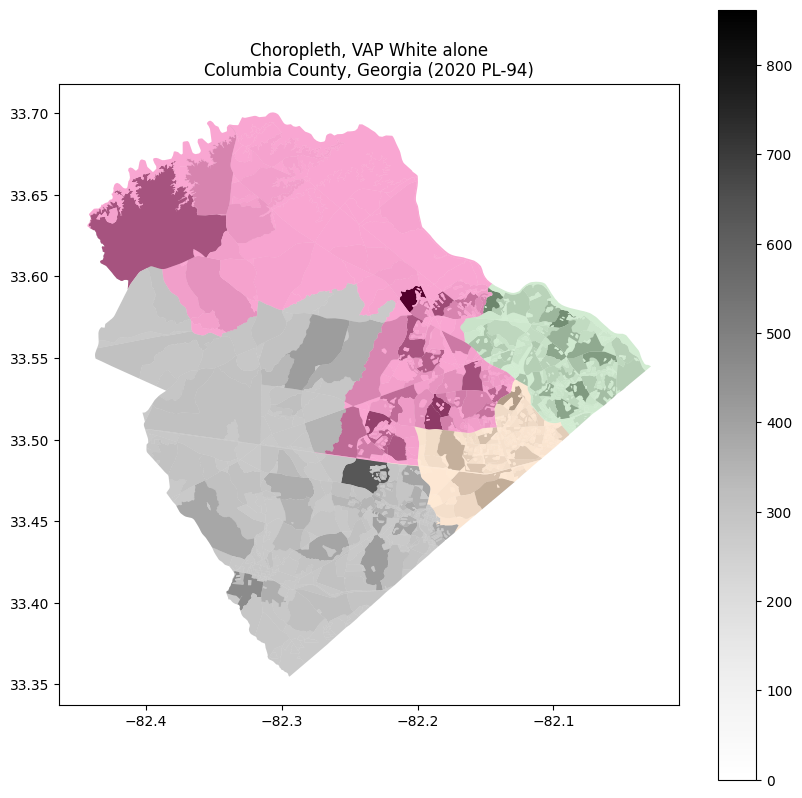

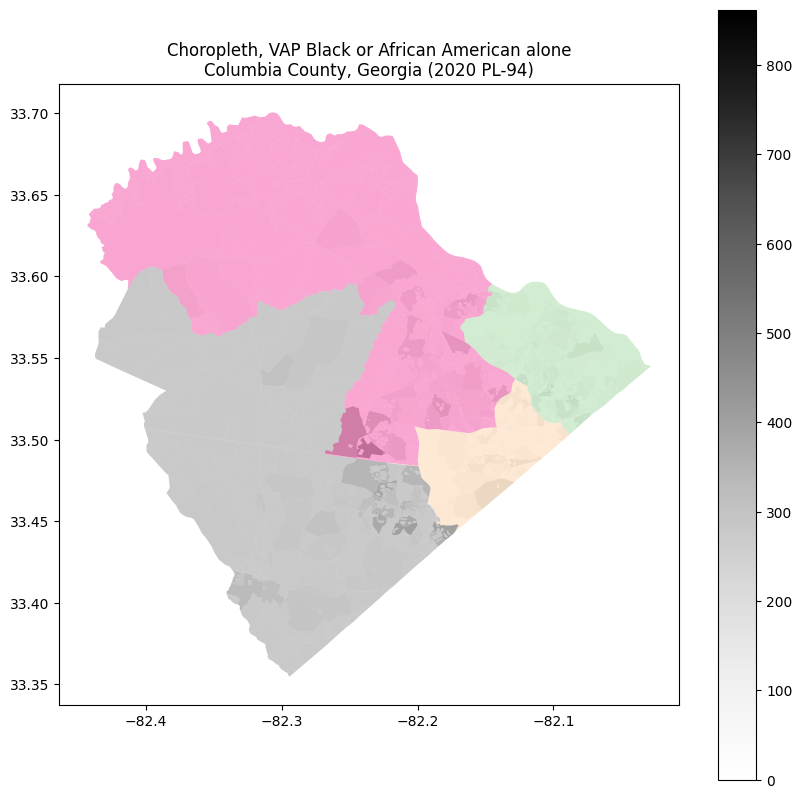

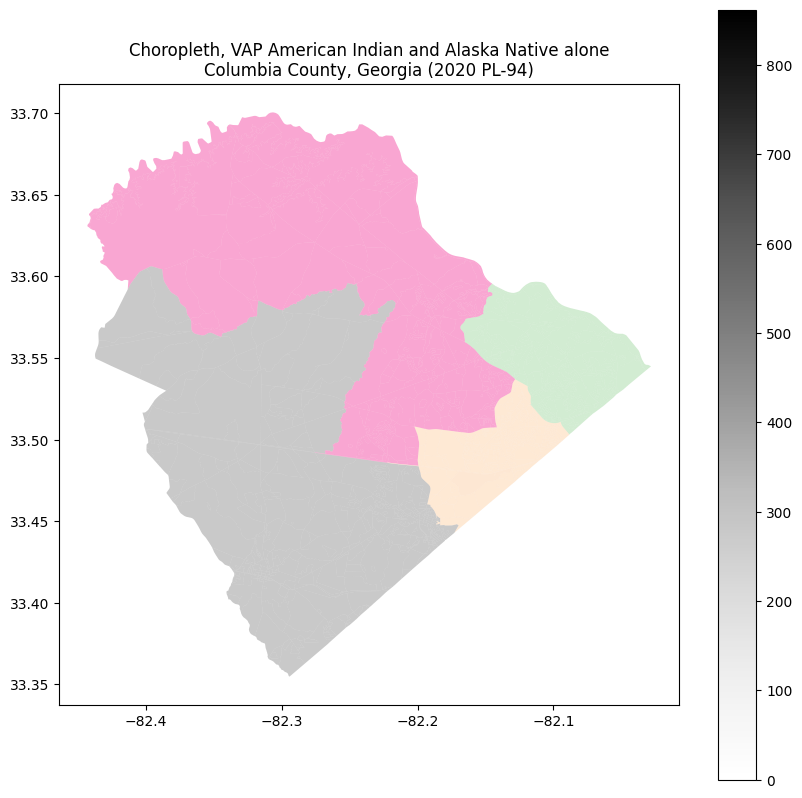

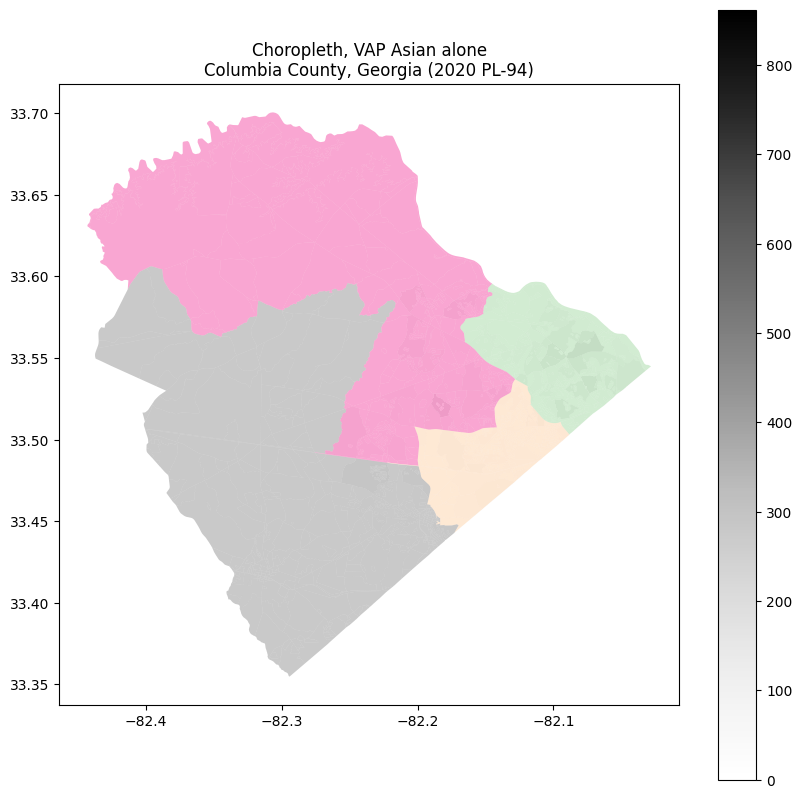

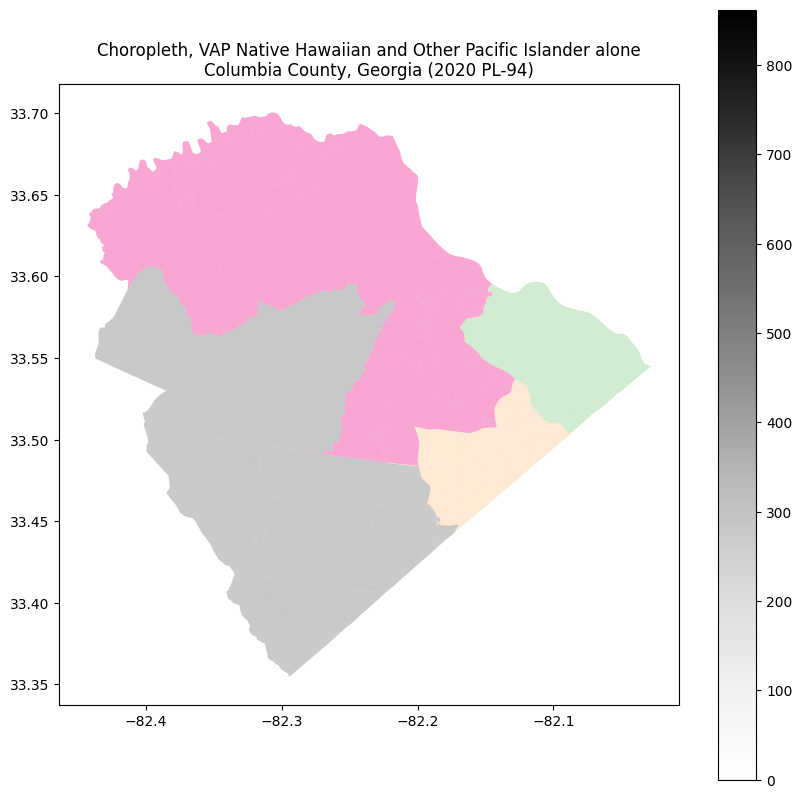

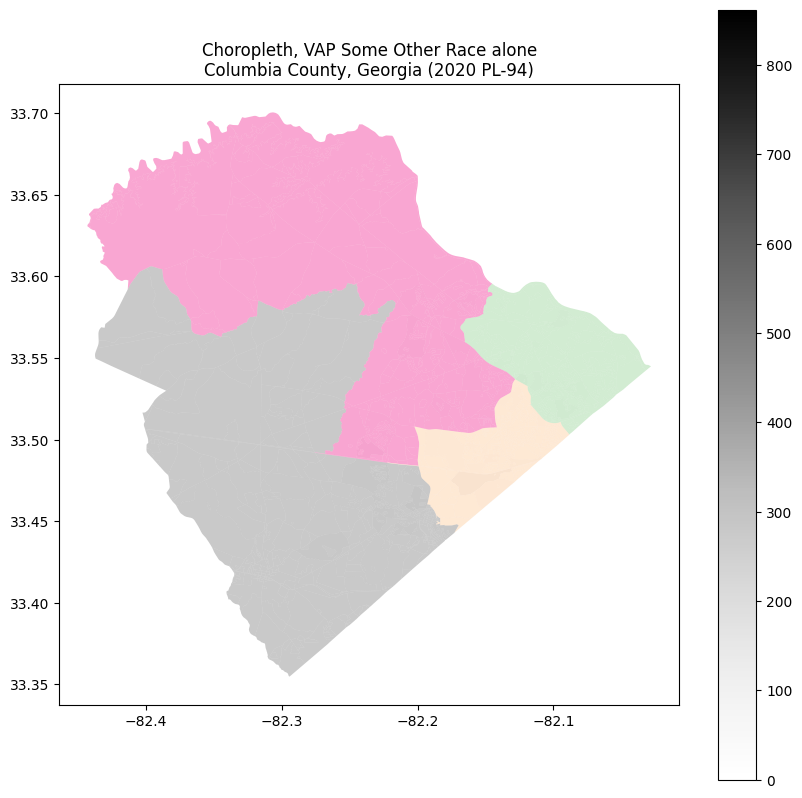

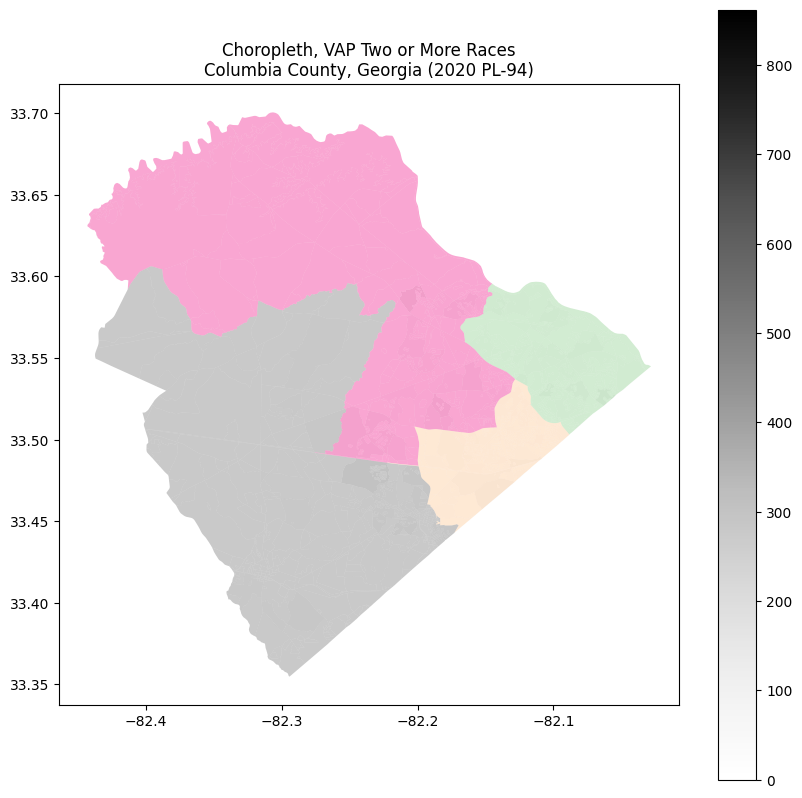

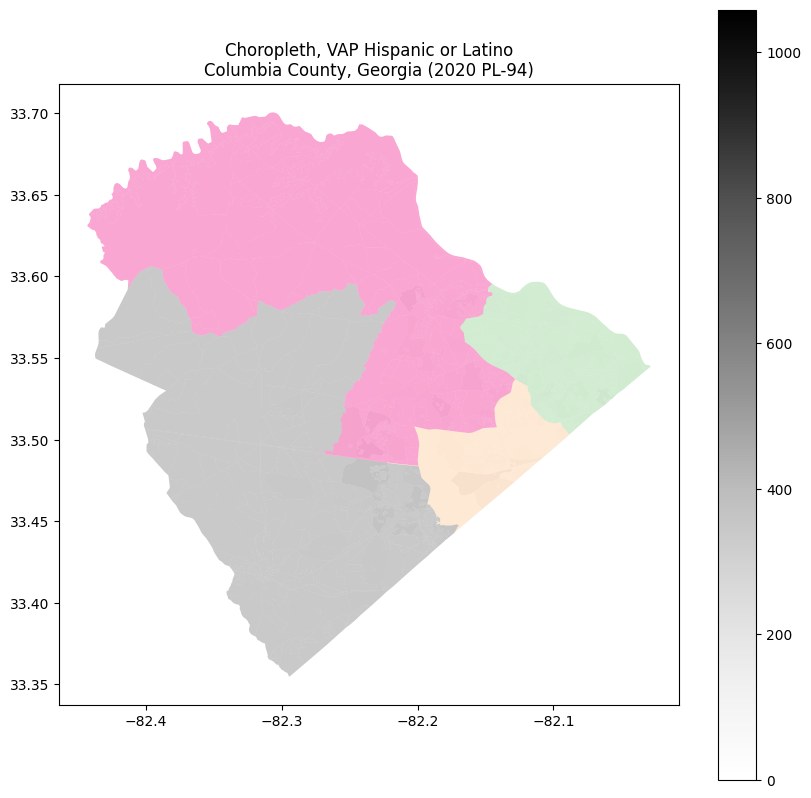

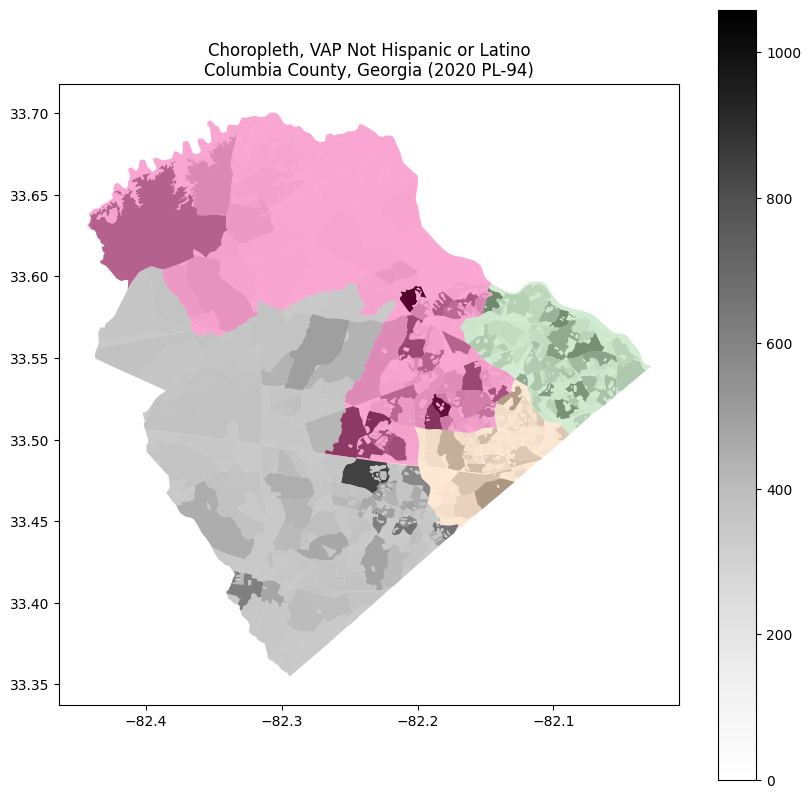

In [516]:





def plot_field_demo(
    field: str,
    group: str,
    vmax: int,
) -> 'plt.Plot':

    # set some plot pieces
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_title(f"Choropleth, VAP {group}\nColumbia County, Georgia (2020 PL-94)")
    
    
    gdf_blocks_plot = gpd.GeoDataFrame(
        pd.merge(
            dict_shps.get(key_blocks),
            df_data[[field_geoid, field]],
            on = [field_geoid]
        )
    )
    
    
    
    # plot demographics
    gdf_blocks_plot.plot(
        alpha = 1,
        ax = ax,
        cmap = "Greys",
        column = field,
        legend = True,
        vmin = 0,
        vmax = vmax,
    )
    
    
    if True:
        # plot district
        gdf_blocks_plot.plot(
            alpha = 0.35,
            ax = ax,
            cmap = "Accent",#"Dark2",
            column = field_district,
        )


    plt.savefig(
        dir_figs.joinpath(f"demographic_distribution_vap_{field}.png"),
        dpi = 200,
        bbox_inches = "tight",
    )


# plot race
for field in fields_race_geq18:
    group = dict_codes_to_descrip.get(field.replace("P003", "P001"))
    vmax = df_data[fields_race_geq18].max().max()
    
    plot_field_demo(
        field,
        group,
        vmax,
    )


# plot ethnicity
for field in fields_ethn_geq18:
    group = dict_codes_to_descrip.get(field.replace("P004", "P002"))
    vmax = df_data[fields_ethn_geq18].max().max()
    
    plot_field_demo(
        field,
        group,
        vmax,
    )

In [17]:
"""


###
###    OPTION TO CHECK FOR TILES THAT DIDN'T GET ASSIGNED TO AN OVERLAY
###


keys = sorted(list(dict_shps.keys()))

fig, ax = plt.subplots(2, 2, figsize = (15, 15))


gdf_block = dict_shps.get(key_blocks)

for k, key in enumerate(keys):

    if key == key_blocks:
        continue

    # get axis point
    j = k%2
    i = int((k - j)/2)

    # look for unassigned blocks
    gdf_unassigned = gdf_block[
        gdf_block[field_assignment(key)].isna()
    ]

    if len(gdf_unassigned) == 0:
        continue
    
    # add to plot
    gdf_plot = dict_shps.get(key)
    gdf_plot.plot(ax = ax[i, j], alpha = 0.04)
    gdf_unassigned.plot(ax = ax[i, j], color = "orange")

    # add some info
    ax[i, j].set_title(key)
    
""";    
    

# First demographic notes: the population 83.5% is either white or black alone
- Leaves significant population of other races, including two or more
- Population distribution is similar for all/VAP
- Small hispanic population (7.6%, 6.4%)

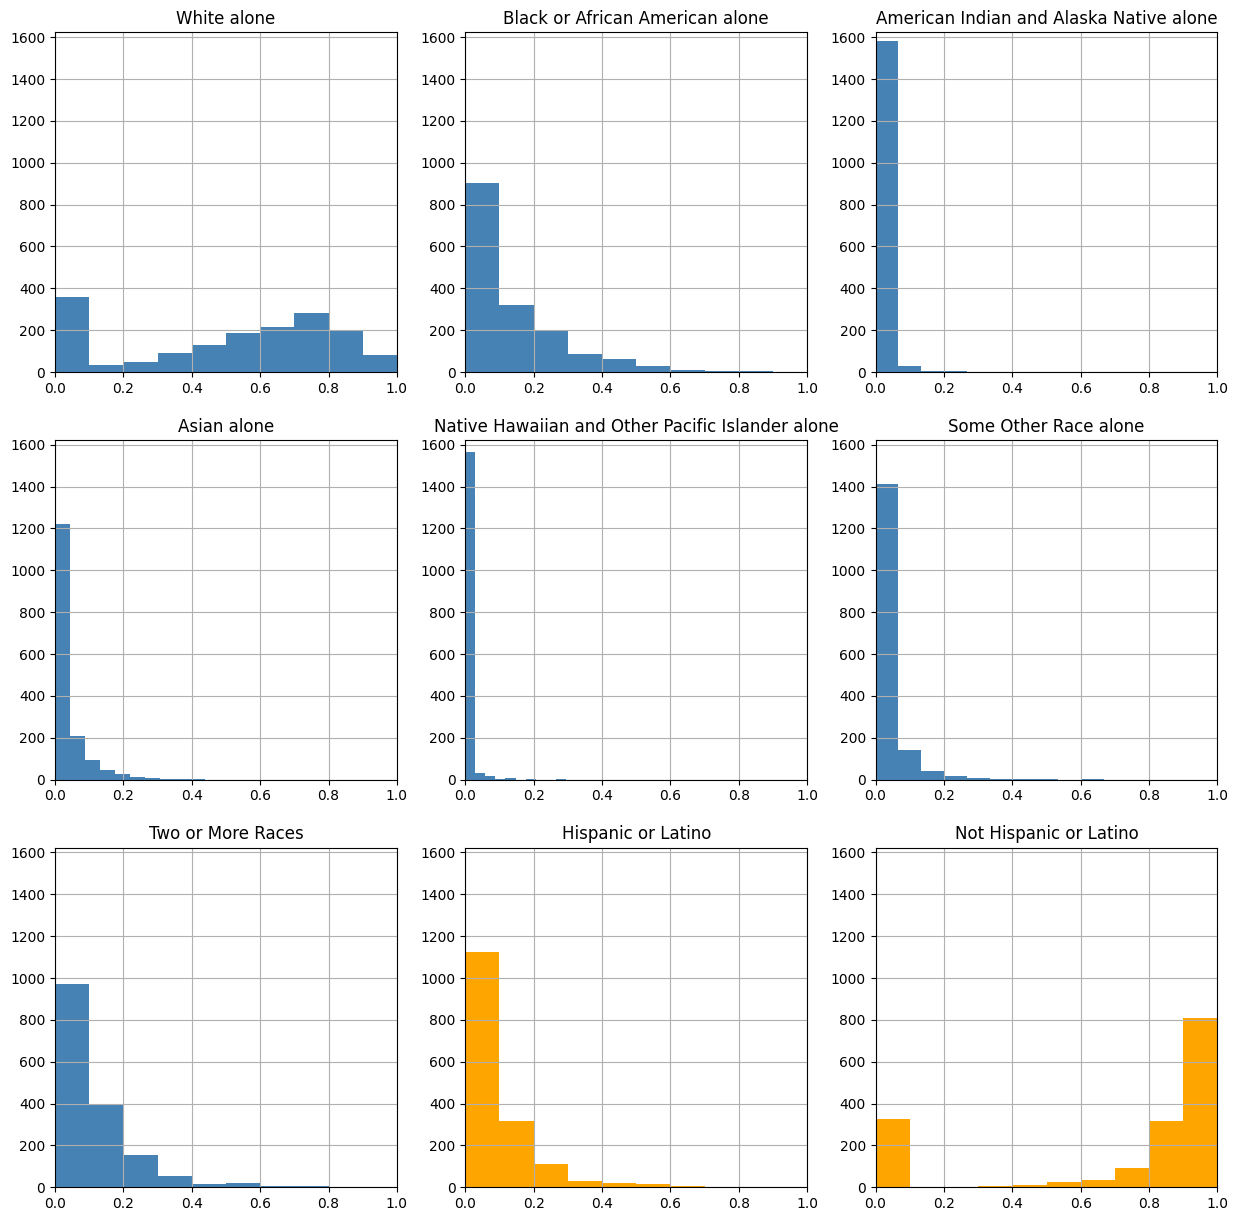

In [472]:
# look at the distribution of population by race 
fig, ax = plt.subplots(3, 3, figsize = (15, 15))


dict_codes_to_descrip = {
    "P0010003": "White alone",
    "P0010004": "Black or African American alone",
    "P0010005": "American Indian and Alaska Native alone",
    "P0010006": "Asian alone",
    "P0010007": "Native Hawaiian and Other Pacific Islander alone",
    "P0010008": "Some Other Race alone",
    "P0010009": "Two or More Races",
    "P0020002": "Hispanic or Latino",
    "P0020003": "Not Hispanic or Latino",
}
keys_add = sorted(dict_codes_to_descrip.keys())

ind = 0
for i in range(3):
    for j in range(3):

        key = keys_add[ind]
        field = f"frac_{key}"

        # format the subplot
        title = dict_codes_to_descrip.get(key)
        ax[i, j].set_title(title)
        #ax[i, j].set_xlabel("Fraction in Group\n")
        #ax[i, j].set_ylabel("Block Count")
        
        ax[i, j].set_xlim(0, 1)
        ax[i, j].set_ylim(0, df_data.shape[0])
        

        ##  BUILD THE HIST

        # set color depending on race or ethnicity
        color = "steelblue" if key.startswith("P001") else "orange"

        # plot it
        (
            df_data[field]
            .hist(
                ax = ax[i, j],
                color = color,
            )
        )

        
        ind += 1


plt.savefig(
    dir_figs.joinpath("demographic_hists.png"),
    dpi = 200,
    bbox_inches = "tight",
)





array([[<Axes: title={'center': 'frac_P0020002'}>,
        <Axes: title={'center': 'frac_P0020003'}>]], dtype=object)

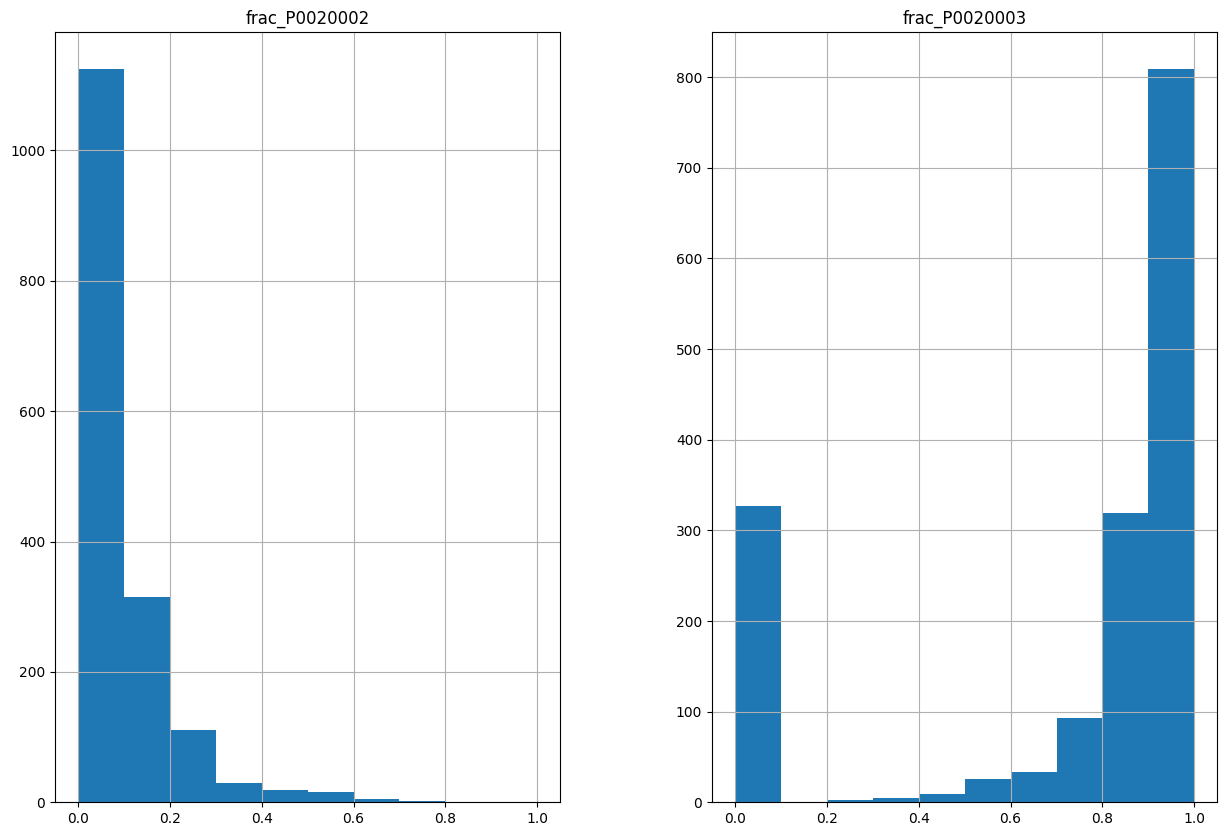

In [19]:
# look at the distribution of population by ethnicity 
fig, ax = plt.subplots(figsize = (15, 10))
df_data[[f"frac_{x}" for x in fields_ethn]].hist(ax = ax)


# Aggregate demographic data to the Precinct level



In [33]:

def agg_data_to_precinct(
    df: pd.DataFrame,
    gdf_blocks: gpd.GeoDataFrame,
    field_precinct: str,
    fields_demographic: List[str],
    fields_turnout: List[str],
    field_geo_key: str = field_geoid,
    fields_add_frac: Union[List[List[str]], None] = None,
) -> dict:
    """
    Get a dictionary to aggregate 
    """

    ## FILTER
    
    fields_data = sorted(
        [
            x for x in fields_demographic + fields_turnout
            if x in df.columns
        ]
    )

    # get the aggregation table
    df_data_agg = (
        pd.merge(
            df[[field_geo_key] + fields_data].copy(),
            gdf_blocks[[field_geo_key, field_precinct]],
            how = "inner",
        )
        .drop(columns = [field_geoid], )
    )

    
    ##  AGGREGATE
    
    dict_agg = get_aggregation_dict(
        df,
        field_precinct,
        fields_demographic,
        fields_turnout,
    )

    df_data_agg = (
        df_data_agg
        .groupby([field_precinct])
        .agg(dict_agg)
        .drop(columns = [field_precinct])
        .reset_index()
    )

    # next, iterate over any fractional fields to add
    if isinstance(fields_add_frac, list):
        
        for grp in fields_add_frac:
            if not isinstance(grp, list):
                continue

            try:
                disp_and_add(
                    grp, 
                    "", 
                    add = True, 
                    disp = False,
                    df = df_data_agg,
                )

            except:
                continue
            

    return df_data_agg



def get_aggregation_dict(
    df: pd.DataFrame,
    field_precinct: str,
    fields_demographic: List[str],
    fields_turnout: List[str],
) -> dict:
    """
    Get a dictionary to aggregate 
    """

    # init with demographics and turnout
    dict_agg = dict(
        (x, "sum")
        for x in fields_demographic + fields_turnout
        if not x.startswith("frac_")
        and x in df.columns
    )
    
    # update with precinct
    dict_agg.update({field_precinct: "first"})

    # add any 
    return dict_agg




##  Actually do the aggregation here

Generate data frames of:

1. Demographic information (PL94) + turnout for precincts used in the 2020 General Election (`df_precinct_demospl94_g2020`)
2. Demographic information (PL94) + turnout for precincts used in the 2022 General Election (`df_precinct_demospl94_g2022`)
3. Demographic information (PL94) + turnout for precincts used in the 2022 Primary Election (`df_precinct_demospl94_p2022`)

In [34]:
##  LOOK AT SOME AGGREGATED PL94 DATA 

# add fractions for these groupings
fields_grp_add = [
    fields_race,
    fields_ethn,
    fields_race_geq18,
    fields_ethn_geq18,
    fields_grpq
]


# general election, 2020
df_precinct_demospl94_g2020 = agg_data_to_precinct(
    df_data,
    dict_shps.get(key_blocks),
    field_assignment("exogenous_gen_20"),
    fields_demographic,
    [x for x in fields_turnout if "2020" in x[0:6]],
    fields_add_frac = fields_grp_add,
) 

# general election, 2022
df_precinct_demospl94_g2022 = agg_data_to_precinct(
    df_data,
    dict_shps.get(key_blocks),
    field_assignment("exogenous_gen_22"),
    fields_demographic,
    [x for x in fields_turnout if "2022" in x[0:6]],
    fields_add_frac = fields_grp_add,
) 

# primary election, 2022
df_precinct_demospl94_p2022 = agg_data_to_precinct(
    df_data,
    dict_shps.get(key_blocks),
    field_assignment("exogenous_prim_22"),
    fields_demographic,
    [x for x in fields_turnout if "2022" in x[0:6]],
    fields_add_frac = fields_grp_add,
) 




In [85]:
## BUILD AGGREGATED CVAP DATA

df_turnout = (
    dict_dfs
    .get("turnout")
    .get(
        [field_geoid] + [
            x for x in dict_dfs.get("turnout").columns
            if (
                ("2022" in x[0:6])
                & ("_pct_" not in x)
                & ("_reg_" not in x)
            )
        ]
    )
)

# format the CVAP df
df_cvap = pd.merge(
    dict_dfs.get("2022cvap"),
    df_turnout,
)

# make two or more races consistent with the census
for prep in ["C", "CVAP"]:
    df_cvap[f"{prep}_TOM22"] = (
        df_cvap[f"{prep}_BLW22"] 
        + df_cvap[f"{prep}_AIW22"] 
        + df_cvap[f"{prep}_ASW22"] 
        + df_cvap[f"{prep}_AIB22"]
    )


    
# build assignments for blocks to precincts
gdf_block = dict_shps.get(key_blocks)
fields_assignment = [field_assignment(k) for k in dict_shps.keys() if k != key_blocks]
df_cvap = df_cvap.merge(
    gdf_block[[field_geoid] + fields_assignment],
    on = [field_geoid],
)

# some fields
fields_demographic_cvap = [
    x for x in dict_dfs.get("2022cvap").columns if x.lower() not in [field_geoid]
]
fields_turnout_cvap = [
    x for x in df_turnout.columns if x.lower() not in [field_geoid]
]

fields_grp_add = [
    # no "some other" race?
    [
        "CVAP_HSP22",
        "CVAP_WHT22",
        "CVAP_BLA22",
        "CVAP_AMI22",
        "CVAP_ASI22",
        "CVAP_NHP22",
        # two or more
        
        "CVAP_BLW22",
        
    ]
]


# general election, 2022
df_precinct_demosacs_g2022 = agg_data_to_precinct(
    df_cvap,
    dict_shps.get(key_blocks),
    field_assignment("exogenous_gen_22"),
    fields_demographic_cvap,
    fields_turnout_cvap,
    fields_add_frac = fields_grp_add,
) 

# primary election, 2022
df_precinct_demosacs_p2022 = agg_data_to_precinct(
    df_cvap,
    dict_shps.get(key_blocks),
    field_assignment("exogenous_prim_22"),
    fields_demographic_cvap,
    fields_turnout_cvap,
    fields_add_frac = fields_grp_add,
)




In [52]:
df_precinct_demosacs_p2022.sort_values(by = ["C_TOT22"], ascending = False, ).head()

,assignment_exogenous_prim_22,C_TOT22,C_HSP22,C_NHS22,C_WHT22,C_BLA22,C_AMI22,C_ASI22,C_NHP22,C_2OM22,...,s20220315_voted_esa,s20220315_voted_oth,s20220315_voted_unk,frac_CVAP_HSP22,frac_CVAP_WHT22,frac_CVAP_BLA22,frac_CVAP_AMI22,frac_CVAP_ASI22,frac_CVAP_NHP22,frac_CVAP_2OM22
23,Grovetown Dept of Public Safety Station #2,6160,761,5402,2574,2448,0,104,0,118,...,0,0,0,0.118042,0.428348,0.430136,0.000000,0.023474,0.0,0.000000
13,Columbia Co. Health Dept.,5386,305,5070,2891,1936,0,89,0,0,...,0,0,0,0.042163,0.522536,0.416691,0.000000,0.018610,0.0,0.000000
22,Grove First Baptist Church,5336,455,4880,2215,1894,0,72,0,164,...,0,0,0,0.089429,0.500388,0.391316,0.000000,0.008529,0.0,0.010339
31,Liberty Park-Grovetown,5236,620,4598,2454,1863,0,4,0,0,...,0,0,0,0.128889,0.442963,0.426963,0.000000,0.001185,0.0,0.000000
30,Lewis Methodist,5132,291,4838,3344,970,1,119,0,40,...,0,0,0,0.050152,0.740371,0.171516,0.000277,0.033527,0.0,0.004156


In [57]:
set(
    df_precinct_demosacs_p2022["assignment_exogenous_prim_22"].unique()
) - set(
    df_precinct_demosacs_g2022["assignment_exogenous_gen_22"].unique()
)

{'Elim Church'}

In [58]:
# for the General election in 2022, the Elim Church was renamed to ACS-Furys Ferry Rd Campus
set(
    df_precinct_demosacs_g2022["assignment_exogenous_gen_22"].unique()
) - set(
    df_precinct_demosacs_p2022["assignment_exogenous_prim_22"].unique()
)

{'ACS-Furys Ferry Rd Campus'}

In [62]:
df_precinct_demosacs_p2022[
    df_precinct_demosacs_p2022["assignment_exogenous_prim_22"].isin(['Elim Church'])
]

,assignment_exogenous_prim_22,C_TOT22,C_HSP22,C_NHS22,C_WHT22,C_BLA22,C_AMI22,C_ASI22,C_NHP22,C_2OM22,...,s20220315_voted_esa,s20220315_voted_oth,s20220315_voted_unk,frac_CVAP_HSP22,frac_CVAP_WHT22,frac_CVAP_BLA22,frac_CVAP_AMI22,frac_CVAP_ASI22,frac_CVAP_NHP22,frac_CVAP_2OM22
15,Elim Church,2060,70,1990,1685,4,0,150,0,20,...,0,0,0,0.020492,0.860656,0.002732,0.0,0.102459,0.0,0.013661


In [60]:
df_precinct_demosacs_g2022[
    df_precinct_demosacs_g2022["assignment_exogenous_gen_22"].isin(['ACS-Furys Ferry Rd Campus'])
]

,assignment_exogenous_gen_22,C_TOT22,C_HSP22,C_NHS22,C_WHT22,C_BLA22,C_AMI22,C_ASI22,C_NHP22,C_2OM22,...,s20220315_voted_esa,s20220315_voted_oth,s20220315_voted_unk,frac_CVAP_HSP22,frac_CVAP_WHT22,frac_CVAP_BLA22,frac_CVAP_AMI22,frac_CVAP_ASI22,frac_CVAP_NHP22,frac_CVAP_2OM22
0,ACS-Furys Ferry Rd Campus,2060,70,1990,1685,4,0,150,0,20,...,0,0,0,0.020492,0.860656,0.002732,0.0,0.102459,0.0,0.013661


In [63]:

def get_endogenous_candidate_counts_wide(
    endogenous_election_key: str, # endogenous_prim_20
) -> dict:
    """
    Based on the endogenous dataset, get the count of votes for each candidate
        as fields
    """
    # prepare ``primary data
    df_primary = dict_dfs.get(endogenous_election_key)
    
    fields_group = [field_contest, field_choice, field_precinct]
    dict_agg = dict((x, "first") for x in fields_group)
    dict_agg.update({field_vote_count: "sum"})
    
    df_primary = (
        df_primary
        .get(dict_agg.keys())
        .groupby(fields_group)
        .agg(dict_agg)
        .reset_index(drop = True)
    )
    
    dict_primaries = {}
    for contest, df in df_primary.groupby([field_contest]):
    
        contest = contest[0]
        df_out = tools.pivot_df_clean(
            df.drop(columns = [field_contest]),
            [field_choice],
            [field_vote_count],
        )
        
        dict_primaries.update({contest: df_out})

    return dict_primaries
    


<Axes: xlabel='P0030004', ylabel='CVAP_BLK22'>

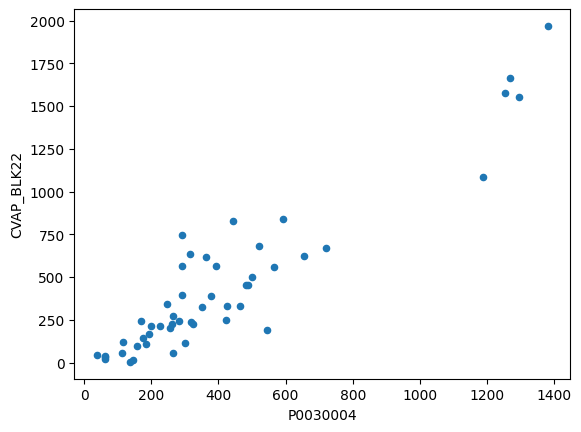

In [73]:
x = "P0030004"
y = "CVAP_BLK22"
key = "assignment_exogenous_prim_22"
df_check = (
    pd.merge(
        df_precinct_demospl94_p2022[[key, x]],
        df_precinct_demosacs_p2022[[key, y]]
    )
    .drop(columns = [key])
)

df_check[[x, y]].plot(x = x, y = y, kind = "scatter", )

# Note: we can't get any information from the Co Commission Dist 3 primary 
- There was only one candidate

In [64]:
dict_pcounts_prim_20 = get_endogenous_candidate_counts_wide("endogenous_prim_20")
df = dict_pcounts_prim_20.get("REP - Co Commission Dist 3")
df



,precinct,Gary Richardson (I)
0,Christ Sanctified,488
1,Col Cty Bd of Edu,440
2,Damascus Baptist Church,286
3,Grace Baptist Church,552
4,Greenbrier High,535
5,Lewis Methodist Church,519
6,New Life Church,372
7,Parkway Baptist Church,771
8,Patriots Park,552
9,Riverview Church,292


# Check out County Commission District 2

In [65]:
df = dict_pcounts_prim_20.get("REP - Co Commission Dist 2")
df

,precinct,Don Skinner,Lee Benedict,Mark E. Petersen,"Robert G. Willis, Jr."
0,Abilene Baptist,175,62,64,69
1,Belair Baptist Church,253,45,54,88
2,Blanchard Park,127,39,34,68
3,Church of Our Savior,164,55,53,73
4,Gold Cross EMS,184,71,56,111
5,Martinez Baptist,112,47,50,45
6,Marvin Methodist,169,44,41,75
7,Mtz Col Fire Hdqtr,96,25,37,21
8,Trinity Baptist Church,287,97,90,120
9,Westside Baptist Church,218,53,53,84


# From endogenous elections data, we may be able to glean some information 

- Was turnout depressed in commission district three precincts? 


In [66]:
# let's see which endogenous races actually had competition
elections = [
    "endogenous_prim_20",
    "endogenous_gen_20",
    "endogenous_prim_22",
    "endogenous_gen_22"
]

for election in elections: 
    
    # get 
    df_election = dict_dfs.get(election)
    dfg = df_election.groupby([field_contest])

    for contest, df in dfg:

        choices = df[field_choice].unique()

        flag_str = "** " if len(choices) == 1 else ""
        msg = f"""{flag_str}Election:\t{election}
        Contest:\t{contest}
        Choices:\t{choices}

        """

        print(msg)



Election:	endogenous_prim_20
        Contest:	('REP - Co Commission Dist 2',)
        Choices:	['Lee Benedict' 'Mark E. Petersen' 'Don Skinner' 'Robert G. Willis, Jr.']

        
** Election:	endogenous_prim_20
        Contest:	('REP - Co Commission Dist 3',)
        Choices:	['Gary Richardson (I)']

        
** Election:	endogenous_gen_20
        Contest:	('County Commission District 2',)
        Choices:	['Don Skinner (Rep)']

        
** Election:	endogenous_gen_20
        Contest:	('County Commission District 3',)
        Choices:	['Gary Richardson (I) (Rep)']

        
** Election:	endogenous_prim_22
        Contest:	('County Commission - District 1 - Rep',)
        Choices:	['Connie M. Melear (I)']

        
Election:	endogenous_prim_22
        Contest:	('County Commission - District 4 - Rep',)
        Choices:	['Alison Couch' 'Dewey G. Galeas (I)']

        
** Election:	endogenous_prim_22
        Contest:	('County Commission Chairperson - Rep',)
        Choices:	['Douglas R. Du

# The only competitive endogenous election with (a) vote tallies and (b) demographic data by precinct is the 2022 primary


<Axes: xlabel='num_votes', ylabel='Alison Couch (Rep)'>

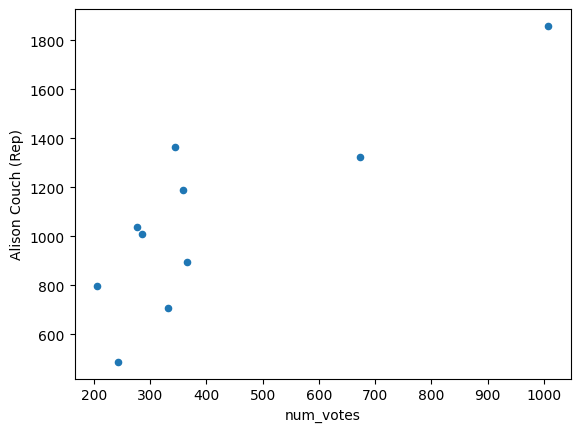

In [75]:
# get 
dict_pcounts_prim_20 = get_endogenous_candidate_counts_wide("endogenous_prim_20")
dict_pcounts_prim_22 = get_endogenous_candidate_counts_wide("endogenous_prim_22")
dict_pcounts_gen_20 = get_endogenous_candidate_counts_wide("endogenous_gen_20")
dict_pcounts_gen_22 = get_endogenous_candidate_counts_wide("endogenous_gen_22")
df_endogenous_turnout_p2020_cd2 = dict_pcounts_prim_20.get("REP - Co Commission Dist 2")
df_endogenous_turnout_p2022_cd4 = dict_pcounts_prim_22.get("County Commission - District 4 - Rep")
df_endogenous_turnout_g2020_cd2 = dict_pcounts_gen_20.get("County Commission District 2")
df_endogenous_turnout_g2022_cd4 = dict_pcounts_gen_22.get("County Commission - District 4")


# add total votes to primary
df_endogenous_turnout_p2022_cd4[field_vote_count] = (
    df_endogenous_turnout_p2022_cd4[
        [
            x for x in df_endogenous_turnout_p2022_cd4.columns
            if x != field_precinct
        ]
    ]
    .sum(axis = 1)
)

df_endogenous_turnout_comparison_cd4 = pd.merge(
    df_endogenous_turnout_p2022_cd4[[field_precinct, field_vote_count]],
    df_endogenous_turnout_g2022_cd4,
)

(
    df_endogenous_turnout_comparison_cd4[
        [field_vote_count, "Alison Couch (Rep)"]
    ]
    .plot(
        x = field_vote_count, 
        y = "Alison Couch (Rep)",
        kind = "scatter",
    )
)

In [91]:
precincts = [x.upper() for x in df_endogenous_turnout_p2022_cd4[field_precinct].unique()]
field_precinct_cur = "assignment_exogenous_prim_22"


def build_endog_p22(
    df_demo: pd.DataFrame, # df_precinct_demospl94_p2022
    df_turnout_endog: pd.DataFrame, # df_endogenous_turnout_p2022_cd4
    field_precinct_cur: str,
) -> pd.DataFrame:
    """
    Build data frame for endogenous elections analysis in 2022 primary. 
        df_demo is the demographic base data to use
    """

    df_endog = df_demo.copy()
    #df_endog[field_precinct_cur] = [x.upper() for x in list(df_endog[field_precinct_cur])]
    
    
    df_endog = (
        pd.merge(
            df_endog,
            df_turnout_endog,
            left_on = field_precinct_cur,
            right_on = field_precinct,
        )
        .drop(columns = [field_precinct_cur])
    )

    # set vote share
    df_endog["vs_couch"] = df_endog["Alison Couch"].to_numpy()/df_endog[field_vote_count].to_numpy()
    df_endog["vs_galeas"] = df_endog["Dewey G. Galeas (I)"].to_numpy()/df_endog[field_vote_count].to_numpy()

    return df_endog


# build endogenous data using ACS and PL94
df_endog_p22_acs = build_endog_p22(
    df_precinct_demosacs_p2022,
    df_endogenous_turnout_p2022_cd4,
    field_precinct_cur,
)

df_endog_p22_pl94 = build_endog_p22(
    df_precinct_demospl94_p2022,
    df_endogenous_turnout_p2022_cd4,
    field_precinct_cur,
)




<Axes: xlabel='frac_P0030004', ylabel='vs_galeas'>

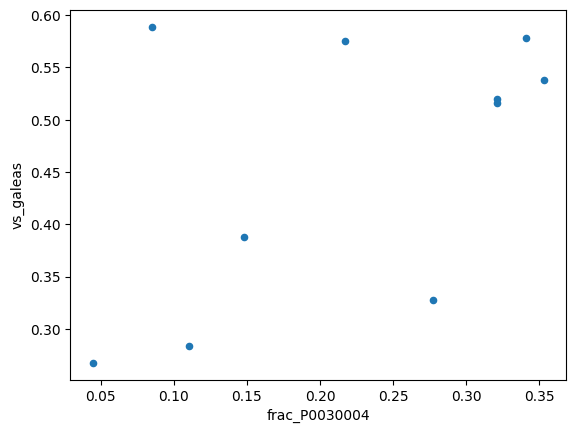

In [93]:
# use VAP frac v. vs for Galaes
x, y = "frac_P0030004", "vs_galeas"
df_endog_p22_pl94[[x, y]].plot(x = x, y = y, kind = "scatter")


<Axes: xlabel='frac_CVAP_BLA22', ylabel='vs_galeas'>

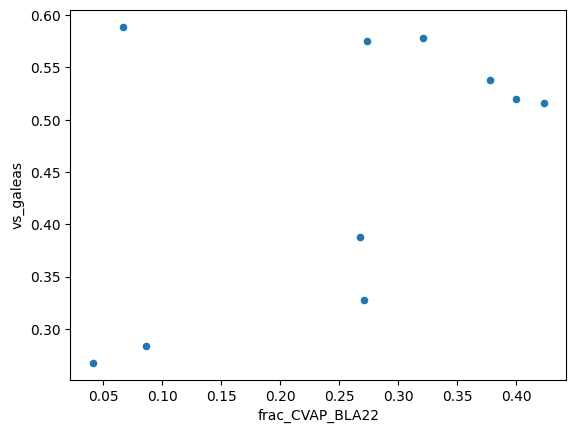

In [94]:
# use CVAP frac v. vs for Galaes
x, y = "frac_CVAP_BLA22", "vs_galeas"
df_endog_p22_acs[[x, y]].plot(x = x, y = y, kind = "scatter")


In [95]:
# check candidates
[
    x for x in df_endog_p22_acs.columns if x.startswith("vs")
]

['vs_couch', 'vs_galeas']

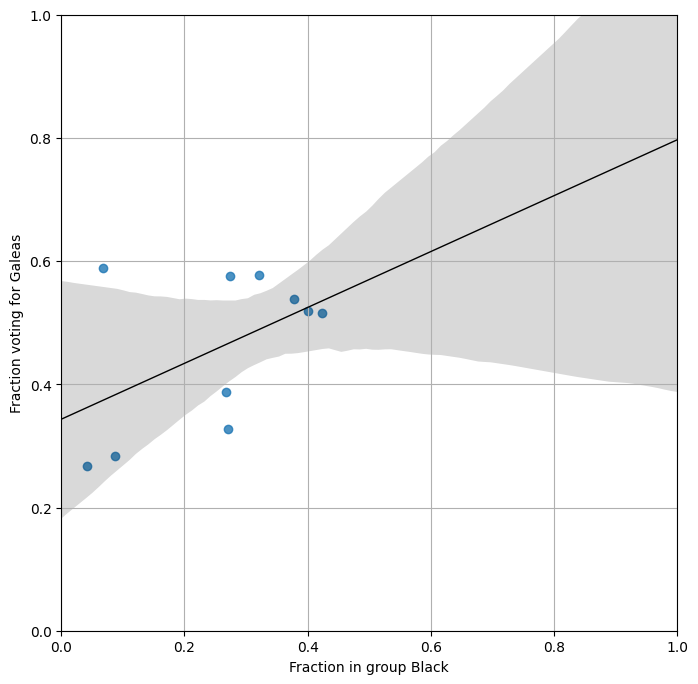

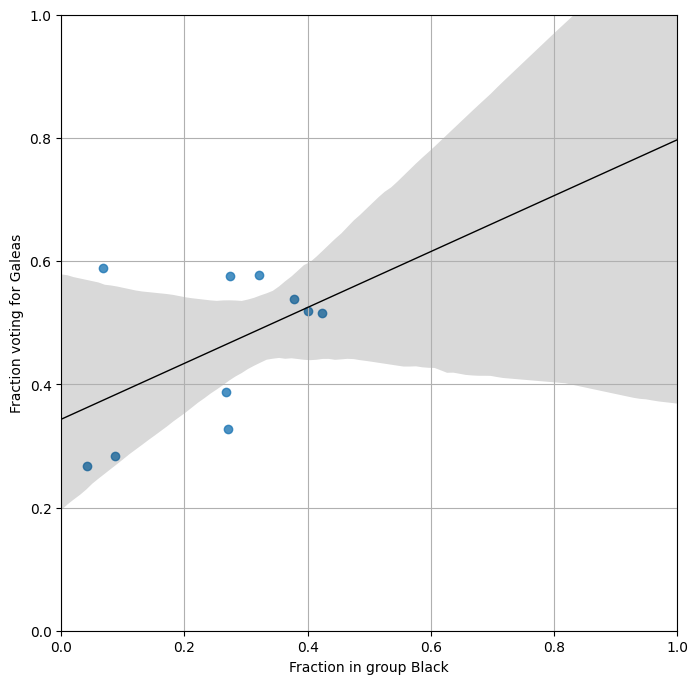

In [548]:
import seaborn as sns

# modified from pyei to allow for subplots info
def plot_ger(
    goodmans_er: 'GoodmansER', 
    subplots: Union[tuple, None],
    **sns_regplot_args
):
    """Plot the linear regression with 95% confidence interval

    Notes:
    ------
    Can pass additional plot arguments through to seaborn.regplot, e.g.
    to change the line color:
        line_kws=dict(color="red")
        scatter_kws={"s": 50}
    """

    fig, ax = (
        plt.subplots()
        if not isinstance(subplots, tuple)
        else subplots
    )
    
    ax.axis("square")
    ax.grid(visible=True, which="major")
    ax.set_ylim((0, 1))
    ax.set_xlim((0, 1))
    ax.set_xlabel(f"Fraction in group {goodmans_er.demographic_group_name}")
    ax.set_ylabel(f"Fraction voting for {goodmans_er.candidate_name}")
    sns.regplot(
        x=goodmans_er.demographic_group_fraction,
        y=goodmans_er.vote_fraction,
        ax=ax,
        ci=95,
        truncate=False,
        **sns_regplot_args,
    )
    return fig, ax

# Fitting Goodman's ER - precincts weighted by population
def get_goodman_er(
    df: pd.DataFrame,
    field_frac: str, # "frac_P0040003"
    field_vs: str, # "vs_galeas"
    demographic_group_name: str,
    candidate_name: str,
    fields_complete: List[str], # fields_race_geq18 - space of groups to summer over fields_race_geq18
) -> 'plt.Plot':
    """
    Generate Goodman's ER for endogenous election data
    """
    group_fraction = df[field_frac].to_numpy()
    votes_fraction = df[field_vs].to_numpy()
    precinct_pops = df[fields_complete].sum(axis = 1)
    
    # Create a GoodmansER object
    goodmans_er = GoodmansER(
        is_weighted_regression = True,
    )
    
    # Fit the model
    goodmans_er.fit(
        group_fraction,
        votes_fraction,
        precinct_pops,
        demographic_group_name = demographic_group_name,
        candidate_name = candidate_name,
    )


    ##  PLOT

    fig, ax = plt.subplots(figsize = (10, 8))
    
    fig, ax = plot_ger(
        goodmans_er,
        line_kws = {"color": "black", "lw": 1},
        subplots = (fig, ax, )
    )
    plt.show()

    return fig, ax
    
#df_endog["p20220524_voted_aa"].to_numpy()
# Generate a simple report to summarize the results
# - 
# - we can tell that we can't get anything from this information


##
##   CHECK BLACK SUPPORT FOR GALEAS
##

# try weighting by L2 estimated turnout
plot = get_goodman_er(
    df_endog_p22_acs, # df_endog_p22_pl94
    "frac_CVAP_BLA22", # frac_P0030004
    "vs_galeas",
    demographic_group_name = "Black",
    candidate_name = "Galeas",
    fields_complete = ["p20220524_voted_aa"],#fields_race_geq18,
)

 
if True:
    plot[0].savefig(
        dir_figs.joinpath("goodman_er_00004_vs_galeas_p2022_weighted_by_l2_aa_turnout.png"),
        dpi = 200,
        bbox_inches = "tight",
    )


# try weighting by precinct population
plot = get_goodman_er(
    df_endog_p22_acs, # df_endog_p22_pl94
    "frac_CVAP_BLA22", # frac_P0030004
    "vs_galeas",
    demographic_group_name = "Black",
    candidate_name = "Galeas",
    fields_complete = ["CVAP_TOT22"],#fields_race_geq18,
)

if True:
    plot[0].savefig(
        dir_figs.joinpath("goodman_er_00004_vs_galeas_p2022_weighted_by_precinct_population.png"),
        dpi = 200,
        bbox_inches = "tight",
    )



In [ ]:
##
##   CHECK BLACK SUPPORT FOR GALEAS
##

# try weighting by L2 estimated turnout
plot = get_goodman_er(
    df_endog_p22_acs, # df_endog_p22_pl94
    "frac_CVAP_BLA22", # frac_P0030004
    "vs_galeas",
    demographic_group_name = "Black",
    candidate_name = "Galeas",
    fields_complete = ["p20220524_voted_aa"],#fields_race_geq18,
)

 
if True:
    plot[0].savefig(
        dir_figs.joinpath("goodman_er_00004_vs_galeas_p2022_weighted_by_l2_aa_turnout.png"),
        dpi = 200,
        bbox_inches = "tight",
    )


# try weighting by precinct population
plot = get_goodman_er(
    df_endog_p22_acs, # df_endog_p22_pl94
    "frac_CVAP_BLA22", # frac_P0030004
    "vs_galeas",
    demographic_group_name = "Black",
    candidate_name = "Galeas",
    fields_complete = ["CVAP_TOT22"],#fields_race_geq18,
)

if True:
    plot[0].savefig(
        dir_figs.joinpath("goodman_er_00004_vs_galeas_p2022_weighted_by_precinct_population.png"),
        dpi = 200,
        bbox_inches = "tight",
    )

In [113]:
def get_two_by_two_ei(
    df: pd.DataFrame,
    field_frac: str, # "frac_P0040003"
    field_vs: str, # "vs_galeas"
    demographic_group_name: str,
    candidate_name: str,
    fields_complete: List[str], # fields_race_geq18 - space of groups to summer over fields_race_geq18
) -> 'plt.Plot':
    """
    Generate Goodman's ER for endogenous election data
    """
    group_fraction = df[field_frac].to_numpy()
    votes_fraction = df[field_vs].to_numpy()
    precinct_pops = df[fields_complete].sum(axis = 1).to_numpy()

    # Create a TwobyTwoEI object
    ei_2by2 = pyei.TwoByTwoEI(
        model_name = "king99_pareto_modification", 
        #pareto_scale = 15, 
        #pareto_shape = 2,
    )
    
    # Fit the model
    ei_2by2.fit(
        group_fraction,
        votes_fraction,
        precinct_pops,
        demographic_group_name = demographic_group_name,
        candidate_name = candidate_name,
        #precinct_names = precinct_names,
        draws = 1200, # optional
        tune = 3000, # optional
        target_accept = .99# optional
    )

    return ei_2by2





ei_cur = get_two_by_two_ei(
    df_endog_p22_acs, # df_endog_p22_pl94
    "frac_CVAP_BLA22", # frac_P0030004
    "vs_galeas",
    demographic_group_name = "Black",
    candidate_name = "Galeas",
    fields_complete = ["CVAP_TOT22"],
)

Compiling.. :   0%|                                    | 0/4200 [00:00<?, ?it/s]

  0%|                                                  | 0/4200 [00:00<?, ?it/s]

Compiling.. :   0%|                                    | 0/4200 [00:00<?, ?it/s]


  0%|                                                  | 0/4200 [00:00<?, ?it/s]


Running chain 1:   0%|                                 | 0/4200 [00:00<?, ?it/s]

Running chain 2:   0%|                                 | 0/4200 [00:00<?, ?it/s]


Running chain 1:   5%|█                     | 210/4200 [00:01<00:06, 619.20it/s]

Running chain 0:   5%|█                     | 210/4200 [00:01<00:10, 386.59it/s]


Running chain 1:  10%|██▏                   | 420/4200 [00:01<00:05, 660.35it/s]

Running chain 0:  10%|██▏                   | 420/4200 [00:01<00:07, 514.36it/s]


Running chain 1:  15%|███▎                  | 630/4200 [00:01<00:04, 714.67it/s]

Running chain 0:  15%|███▎                  | 630/4200 [00:02<00:06, 556.59it/s]


Running ch

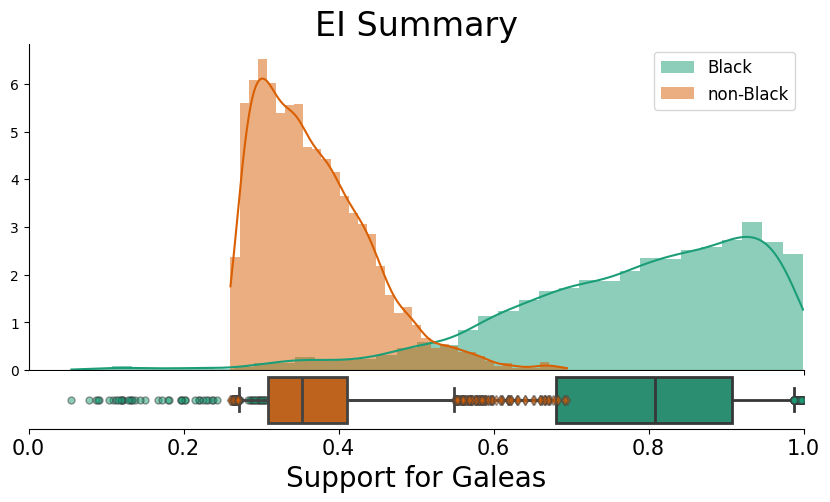

In [539]:
ei_cur.plot()
plt.savefig(
    dir_figs.joinpath("ei_summary_plot_endog_p2022_black_galeas.png"),
    dpi = 200,
    bbox_inches = "tight",
)



In [537]:
ei_2022_white = get_two_by_two_ei(
    df_endog_p22_acs, # df_endog_p22_pl94
    "frac_CVAP_WHT22", # frac_P0030004
    "vs_couch",
    demographic_group_name = "White",
    candidate_name = "Couch",
    fields_complete = ["CVAP_TOT22"],
)

Compiling.. :   0%|                                    | 0/4200 [00:00<?, ?it/s]

  0%|                                                  | 0/4200 [00:00<?, ?it/s]

Compiling.. :   0%|                                    | 0/4200 [00:00<?, ?it/s]


  0%|                                                  | 0/4200 [00:00<?, ?it/s]


Running chain 1:   0%|                                 | 0/4200 [00:00<?, ?it/s]

Running chain 2:   0%|                                 | 0/4200 [00:00<?, ?it/s]


Running chain 3:   0%|                                 | 0/4200 [00:00<?, ?it/s]

Running chain 2:   5%|█                     | 210/4200 [00:01<00:06, 586.10it/s]


Running chain 1:   5%|█                     | 210/4200 [00:01<00:08, 483.34it/s]


Running chain 0:  10%|██▏                   | 420/4200 [00:01<00:05, 640.83it/s]

Running chain 1:  10%|██▏                   | 420/4200 [00:01<00:06, 590.77it/s]


Running chain 3:  15%|███▎                  | 630/4200 [00:01<00:05, 676.34it/s]

Running ch

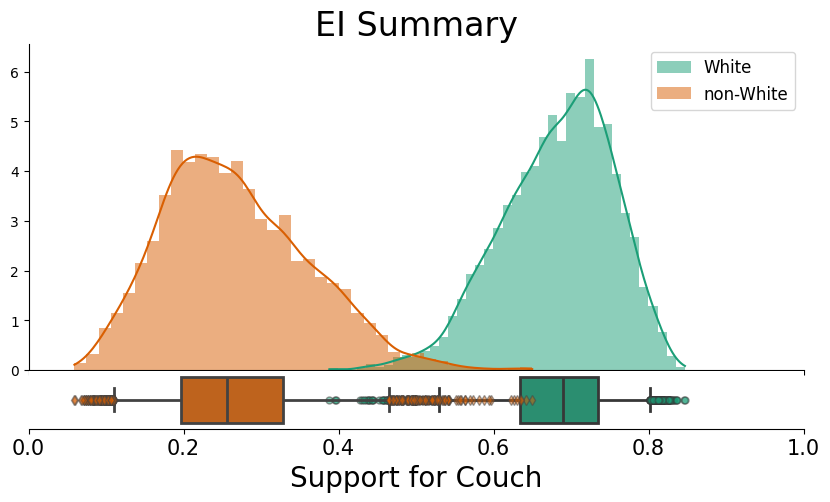

In [540]:
ei_2022_white.plot()
plt.savefig(
    dir_figs.joinpath("ei_summary_plot_endog_p2022_white_couch.png"),
    dpi = 200,
    bbox_inches = "tight",
)

In [120]:
# try weighted by turnout
ei_cur2 = get_two_by_two_ei(
    df_endog_p22_acs, # df_endog_p22_pl94
    "frac_CVAP_BLA22", # frac_P0030004
    "vs_galeas",
    demographic_group_name = "Black",
    candidate_name = "Galeas",
    fields_complete = ["p20220524_voted_aa"],
)


Compiling.. :   0%|                                    | 0/4200 [00:00<?, ?it/s]

  0%|                                                  | 0/4200 [00:00<?, ?it/s]

Compiling.. :   0%|                                    | 0/4200 [00:00<?, ?it/s]


  0%|                                                  | 0/4200 [00:00<?, ?it/s]


Running chain 1:   0%|                                 | 0/4200 [00:00<?, ?it/s]

Running chain 2:   0%|                                 | 0/4200 [00:00<?, ?it/s]


Running chain 3:   0%|                                 | 0/4200 [00:00<?, ?it/s]


Running chain 0:   5%|█                    | 210/4200 [00:01<00:03, 1156.02it/s]

Running chain 1:   5%|█                     | 210/4200 [00:01<00:04, 891.52it/s]


Running chain 0:  10%|██                   | 420/4200 [00:01<00:02, 1433.93it/s]

Running chain 0:  15%|███▏                 | 630/4200 [00:01<00:02, 1616.09it/s]

Running chain 1:  15%|███▏                 | 630/4200 [00:01<00:02, 1302.17it/s]


Running ch

(<Axes: xlabel='Support for Galeas'>, <Axes: title={'center': 'EI Summary'}>)

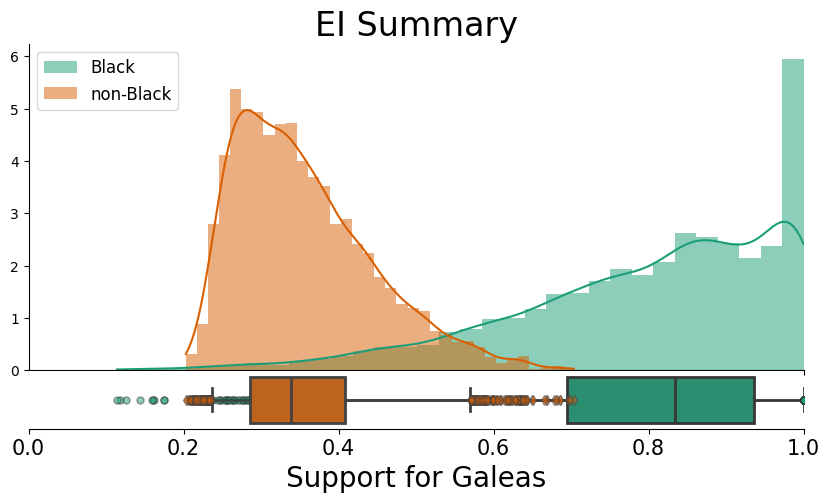

In [121]:
ei_cur2.plot()

# Move to Exogenous Elections (General 2020)# Take a look at the 2020 Exogenous Elections

- First, we can examine whether there was any kind of correlation between demographic groups of voters and candidates
    - Let's look by racial and ethnic groups
    - Extract turnout numbers only; it's unclear if L2's racial and ethnic groups correspond precisely with the Census (e.g., Hispanic and Portuguese are together)

In [139]:
# use VAP instead of CVAP estimate, which was available in ACS

field_precinct_cur = "assignment_exogenous_gen_20"

df_exog_g20 = (
    pd.merge(
        dict_shps.get("exogenous_gen_20"),
        df_precinct_demospl94_g2020,
        left_on = field_precinct,
        right_on = field_precinct_cur,
    )
    .drop(columns = [field_precinct_cur])
)


# normalize some fields by VAP
fields_norm = [
    'G20PRERTRU', 'G20PREDBID',
    'G20PRELJOR', 'C20PRERTRU', 'C20PREDBID', 'C20PRELJOR', 'G20USSRPER',
    'G20USSDOSS', 'G20USSLHAZ', 'S20USSRLOE', 'S20USSRCOL', 'S20USSRGRA',
    'S20USSRJAC', 'S20USSRTAY', 'S20USSRJOH', 'S20USSDWAR', 'S20USSDJAC',
    'S20USSDLIE', 'S20USSDJOH', 'S20USSDJAM', 'S20USSDSLA', 'S20USSDWIN',
    'S20USSDTAR', 'S20USSLSLO', 'S20USSGFOR', 'S20USSIBUC', 'S20USSIBAR',
    'S20USSISTO', 'S20USSIGRE', 'G20PSCRSHA', 'G20PSCDBRY', 'G20PSCLMEL',
    'G20PSCRMCD', 'G20PSCDBLA', 'G20PSCLWIL', 'R21USSRPER', 'R21USSDOSS',
    'R21USSRLOE', 'R21USSDWAR', 'R21PSCRMCD', 'R21PSCDBLA'
]


vec_total = df_exog_g20[fields_race_geq18].sum(axis = 1)

for field in fields_norm:
    field_new = f"frac_{field}"
    df_exog_g20[field_new] = df_exog_g20[field].to_numpy()/vec_total
    

##  Get info on fields for grouping

In [521]:
class ElectionField:

    def __init__(self,
        field: str,
    ) -> None:

        if not isinstance(field, str):
            raise RuntimeError(f"invalid input for field. Must be a string.")

        self._init_properties(field)

        return None


    def _init_properties(self,
        field: str,                    
    ) -> None:
        """
        Initialize party, year, election, and candidate abv
        """

        self.candidate = field[7:]
        self.election_type = field[0]
        self.name = field
        self.office = field[3:6]
        self.party = field[6]
        self.year = int(field[1:3]) + 2000
        
        return None
        
fields_candidates_2020 = [ElectionField(x) for x in fields_norm]


## get fields for heatmap grouping -- try by party for RPV
"""dict_grouping = {}

for fld in fields_candidates_2020:
    if fld.party not in dict_grouping.keys():
        dict_grouping.update({fld.party: [fld.name]})
        continue

    # add to the output
    dict_grouping.get(fld.party).append(fld.name)

for v in dict_grouping.values():
    v.sort()"""

list_sort_inds = fields_candidates_2020.copy()
def sort_key(
    fld: ElectionField,
) -> tuple:

    inds = (
        fld.party,
        fld.office,
        fld.election_type,
        fld.year,
        fld.candidate
    )

    return inds
#for fld in fields_candidates_2020:#
    #list_sort_inds.append((inds, fld.name))


list_sort_inds.sort(key = sort_key)

def get_fields_by_election_type(
    election_type: str,
) -> List[str]:
    out = [x.name for x in list_sort_inds if (x.year == 2020) & (x.election_type == election_type)]

    return out




###   Build a correlation matrix between fraction by demographic group and fraction VAP supporting candidate
- Isn't perfect (unweighted), b
- ut gives us insight into which groups support which candidates

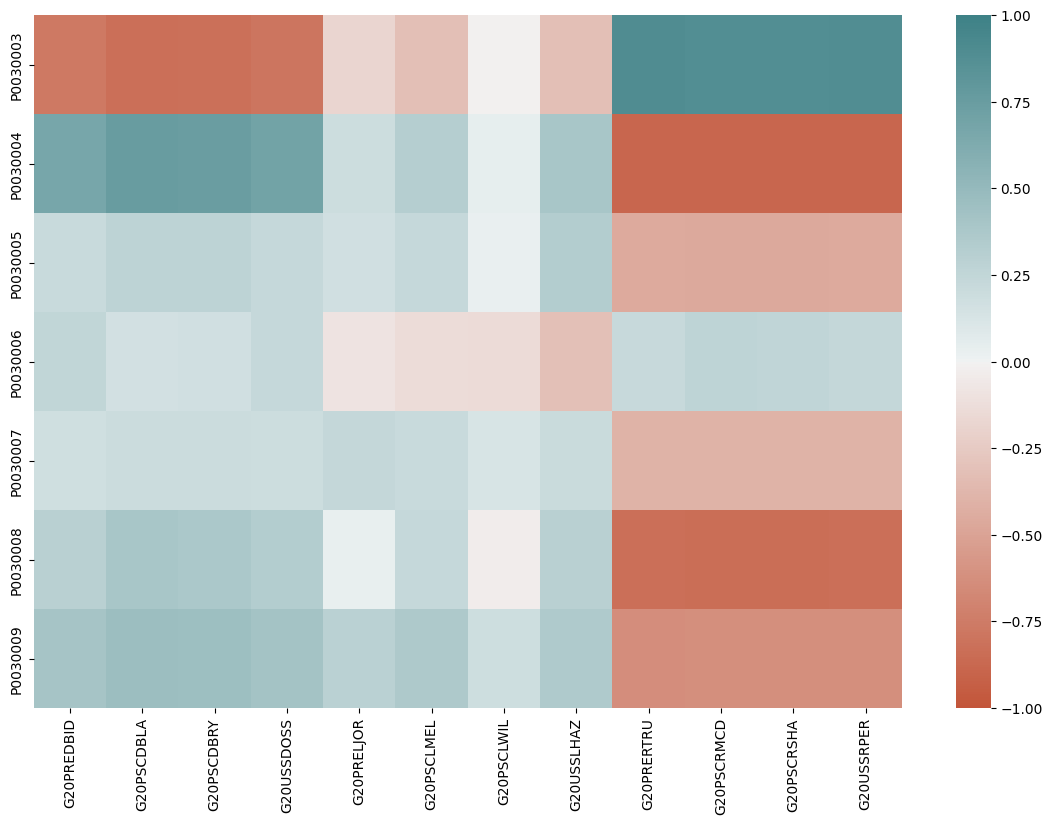

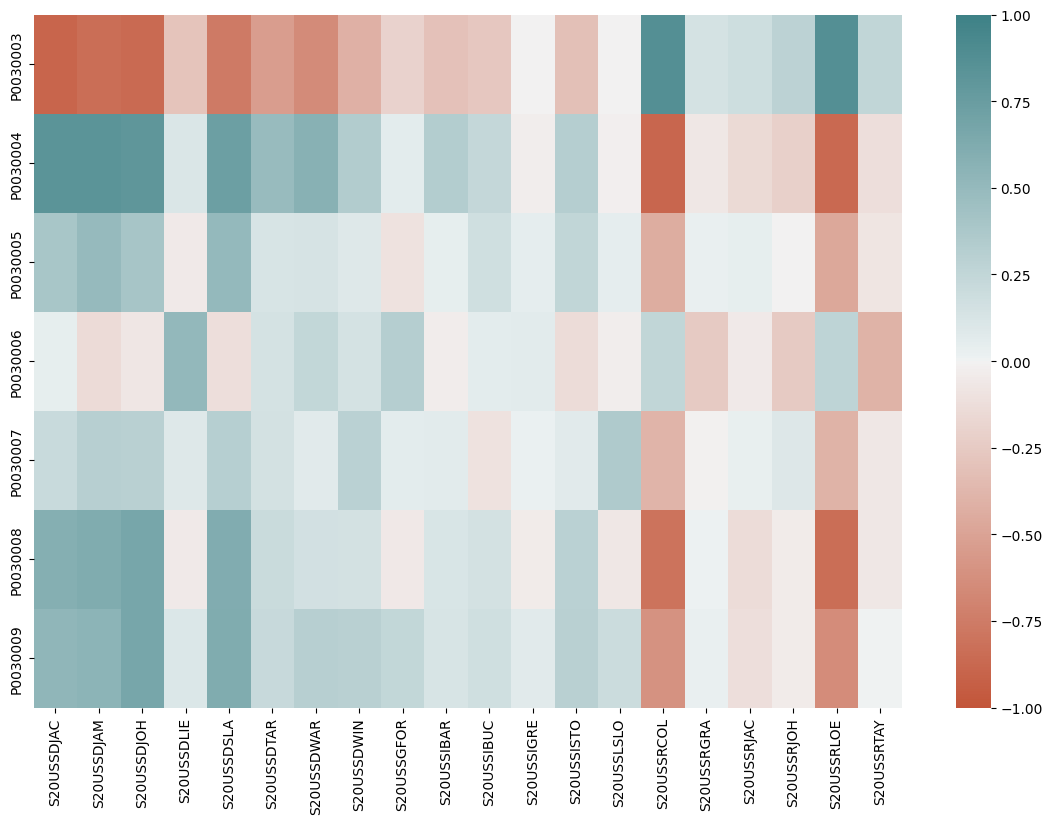

In [524]:

# use a weighted corrcoef
dsw = statsmodels.stats.weightstats.DescrStatsW
vec_total_vap = (
    df_exog_g20[fields_race_geq18]
    .sum(axis = 1)
    .to_numpy()
)


for election_type in ["G", "S"]:

    fields_candidates_disp = get_fields_by_election_type(election_type)
    mat = np.zeros((len(fields_race_geq18), len(fields_candidates_disp)))
    
    for i, field_i in enumerate(fields_race_geq18):
        field_i = f"frac_{field_i}"
        
        for j, field_j in enumerate(fields_candidates_disp):
            
            field_j = f"frac_{field_j}"
            
            weighted_stats = dsw(
                df_exog_g20[[field_i, field_j]].to_numpy(),
                weights = vec_total_vap,
            )
    
            mat[i, j] = weighted_stats.corrcoef[0, 1]
    
    
    
    fig, ax = plt.subplots(figsize = (14, 9))
    
    palette = sns.diverging_palette(20, 200, as_cmap=True)
    #(fields_candidates_disp)
    sns.heatmap(
        mat, 
        #annot = True,
        ax = ax,
        cmap = palette,
        vmin = -1.0,
        vmax = 1.0,
        xticklabels = fields_candidates_disp,
        yticklabels = fields_race_geq18,
        
    )
    
    plt.savefig(
        dir_figs.joinpath(f"heatmap_gen_2020_candidates_election_type_{election_type}.png"),
        dpi = 200,
        bbox_inches = "tight",
    )


In [258]:
dict_dfs.keys()

dict_keys(['pl2020', 'turnout', '2022cvap', 'endogenous_gen_20', 'endogenous_gen_22', 'endogenous_prim_22', 'endogenous_prim_20'])

In [ ]:
dict_dfs.get("endogenous_gen_20")["contest"]

In [257]:
dict_shps.get("exogenous_gen_22").columns

Index(['UNIQUE_ID', 'COUNTYFP', 'county', 'precinct', 'G22A01NO', 'G22A01YES',
       'G22A02NO', 'G22A02YES', 'G22AGRDHEM', 'G22AGRLRAU',
       ...
       'GSU50DWIL', 'GSU50RHAT', 'GSU51RGOO', 'GSU52RHUF', 'GSU53RMOO',
       'GSU54RPAY', 'GSU55DBUT', 'GSU56DTHO', 'GSU56RALB', 'geometry'],
      dtype='object', length=414)

In [233]:
?sns.heatmap

Signature:
sns.heatmap(
    data,
    *,
    vmin=None,
    vmax=None,
    cmap=None,
    center=None,
    robust=False,
    annot=None,
    fmt='.2g',
    annot_kws=None,
    linewidths=0,
    linecolor='white',
    cbar=True,
    cbar_kws=None,
    cbar_ax=None,
    square=False,
    xticklabels='auto',
    yticklabels='auto',
    mask=None,
    ax=None,
    **kwargs,
)
Docstring:
Plot rectangular data as a color-encoded matrix.

This is an Axes-level function and will draw the heatmap into the
currently-active Axes if none is provided to the ``ax`` argument.  Part of
this Axes space will be taken and used to plot a colormap, unless ``cbar``
is False or a separate Axes is provided to ``cbar_ax``.

Parameters
----------
data : rectangular dataset
    2D dataset that can be coerced into an ndarray. If a Pandas DataFrame
    is provided, the index/column information will be used to label the
    columns and rows.
vmin, vmax : floats, optional
    Values to anchor the colormap, otherwise

In [ ]:
df_cvap[
    df_cvap["CVAP_2OM22"] == df_cvap["CVAP_2OM22"].max()
]
df_cvap.iloc[23].to_dict()

<Axes: xlabel='frac_P0040003', ylabel='frac_G20PRERTRU'>

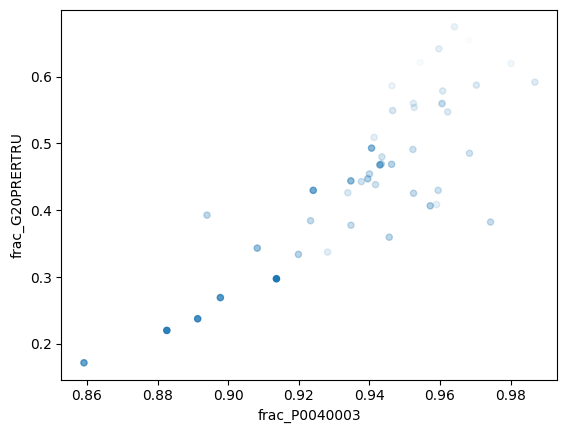

In [138]:

x = "frac_P0040003"
y = "frac_G20PRERTRU"#"frac_G20USSDOSS"#"frac_G20PREDBID"#"frac_G20PRERTRU"
fld_alpha = "g20201103_voted_aa"

df_exog_g20_tmp = df_exog_g20.copy()
df_exog_g20_tmp["alpha"] = df_exog_g20_tmp[fld_alpha]/df_exog_g20_tmp[fld_alpha].max()

(
    df_exog_g20[
        [x, y]
    ]
    .plot(
        x = x,
        y = y,
        kind = "scatter",
        alpha = df_exog_g20_tmp["alpha"].to_numpy()
    )
)

<Axes: xlabel='voter pref of Black for Biden', ylabel='voter pref of non-Black for Biden'>

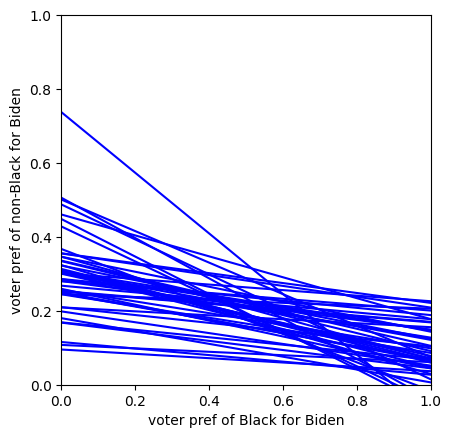

In [318]:
pyei.tomography_plot(
    group_fraction,
    votes_fraction,
    "Black",
    "Biden"
)

In [529]:
for k in df_exog_g20.columns:
    print(k)

DISTRICT
CTYSOSID
PRECINCT_I
precinct
CTYNAME
CTYNUMBER
CTYNUMBER2
COUNTYFP
G20PRERTRU
G20PREDBID
G20PRELJOR
C20PRERTRU
C20PREDBID
C20PRELJOR
G20USSRPER
G20USSDOSS
G20USSLHAZ
S20USSRLOE
S20USSRCOL
S20USSRGRA
S20USSRJAC
S20USSRTAY
S20USSRJOH
S20USSDWAR
S20USSDJAC
S20USSDLIE
S20USSDJOH
S20USSDJAM
S20USSDSLA
S20USSDWIN
S20USSDTAR
S20USSLSLO
S20USSGFOR
S20USSIBUC
S20USSIBAR
S20USSISTO
S20USSIGRE
G20PSCRSHA
G20PSCDBRY
G20PSCLMEL
G20PSCRMCD
G20PSCDBLA
G20PSCLWIL
R21USSRPER
R21USSDOSS
R21USSRLOE
R21USSDWAR
R21PSCRMCD
R21PSCDBLA
geometry
P0010003
P0010004
P0010005
P0010006
P0010007
P0010008
P0010009
P0020002
P0020003
P0030003
P0030004
P0030005
P0030006
P0030007
P0030008
P0030009
P0040002
P0040003
g20201103_voted_all
g20201103_voted_eur
g20201103_voted_hisp
g20201103_voted_aa
g20201103_voted_esa
g20201103_voted_oth
g20201103_voted_unk
pp20200609_voted_all
pp20200609_voted_eur
pp20200609_voted_hisp
pp20200609_voted_aa
pp20200609_voted_esa
pp20200609_voted_oth
pp20200609_voted_unk
p20200609_voted

In [530]:
# try weighted by turnout
ei_cur2 = get_two_by_two_ei(
    df_exog_g20, # df_endog_p22_pl94
    "frac_P0030004", # frac_P0030004
    "frac_C20PREDBID",
    demographic_group_name = "Black",
    candidate_name = "Biden",
    fields_complete = ["g20201103_voted_all"],
)


Compiling.. :   0%|                                    | 0/4200 [00:00<?, ?it/s]

  0%|                                                  | 0/4200 [00:00<?, ?it/s]

Compiling.. :   0%|                                    | 0/4200 [00:00<?, ?it/s]


  0%|                                                  | 0/4200 [00:00<?, ?it/s]


Running chain 1:   0%|                                 | 0/4200 [00:00<?, ?it/s]

Running chain 2:   0%|                                 | 0/4200 [00:00<?, ?it/s]


Running chain 0:   5%|█                     | 210/4200 [00:01<00:06, 652.40it/s]

Running chain 2:   5%|█                     | 210/4200 [00:01<00:07, 561.55it/s]


Running chain 0:  10%|██▏                   | 420/4200 [00:01<00:05, 710.89it/s]

Running chain 2:  10%|██▏                   | 420/4200 [00:01<00:05, 663.28it/s]


Running chain 0:  15%|███▎                  | 630/4200 [00:01<00:05, 692.34it/s]


Running chain 3:  15%|███▎                  | 630/4200 [00:01<00:05, 664.04it/s]

Running ch

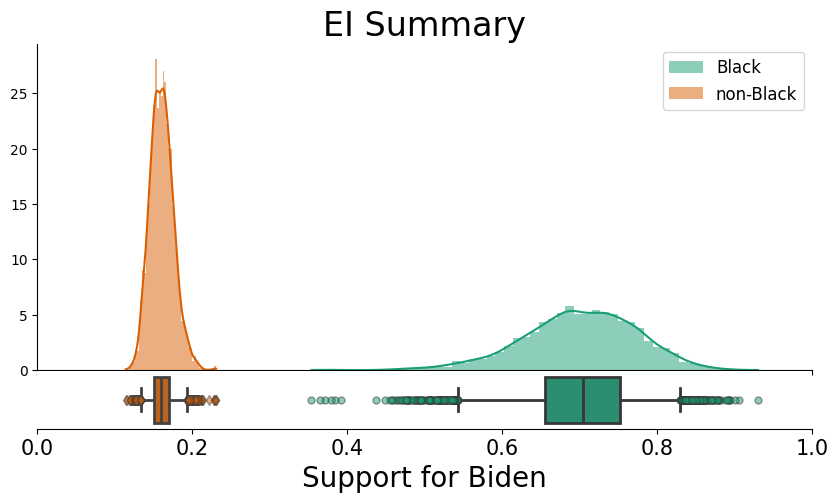

In [541]:

ei_cur2.plot()
# Generate a simple report to summarize the results
plt.savefig(
    dir_figs.joinpath("ei_g2020_black_biden.png"),
    dpi = 200,
    bbox_inches = "tight"
)

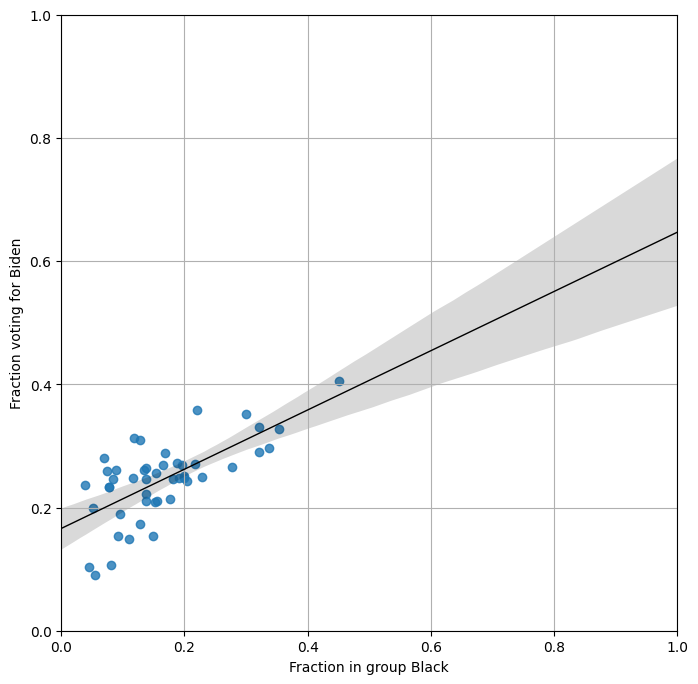

In [549]:
plot = get_goodman_er(
    df_exog_g20, # df_endog_p22_pl94
    "frac_P0030004", # frac_P0030004
    "frac_C20PREDBID",
    demographic_group_name = "Black",
    candidate_name = "Biden",
    fields_complete = ["g20201103_voted_all"],
)


if True:
    plot[0].savefig(
        dir_figs.joinpath("goodman_er_00004_vs_biden_g2020_weighted_by_turnout.png"),
        dpi = 200,
        bbox_inches = "tight",
    )

In [545]:
# try weighted by turnout
ei_cur_white_g20 = get_two_by_two_ei(
    df_exog_g20, # df_endog_p22_pl94
    "frac_P0030003", # frac_P0030004
    "frac_C20PRERTRU",
    demographic_group_name = "White",
    candidate_name = "Trump",
    fields_complete = ["g20201103_voted_all"],
)


Compiling.. :   0%|                                    | 0/4200 [00:00<?, ?it/s]

  0%|                                                  | 0/4200 [00:00<?, ?it/s]

Compiling.. :   0%|                                    | 0/4200 [00:00<?, ?it/s]


  0%|                                                  | 0/4200 [00:00<?, ?it/s]


Running chain 1:   0%|                                 | 0/4200 [00:00<?, ?it/s]

Running chain 2:   0%|                                 | 0/4200 [00:00<?, ?it/s]


Running chain 3:   0%|                                 | 0/4200 [00:00<?, ?it/s]


Running chain 1:   5%|█                     | 210/4200 [00:01<00:14, 272.06it/s]

Running chain 2:   5%|█                     | 210/4200 [00:01<00:20, 196.68it/s]


Running chain 0:   5%|█                     | 210/4200 [00:02<00:27, 144.55it/s]


Running chain 3:  15%|███▎                  | 630/4200 [00:02<00:09, 381.34it/s]

Running chain 1:  20%|████▍                 | 840/4200 [00:03<00:08, 406.69it/s]

Running ch

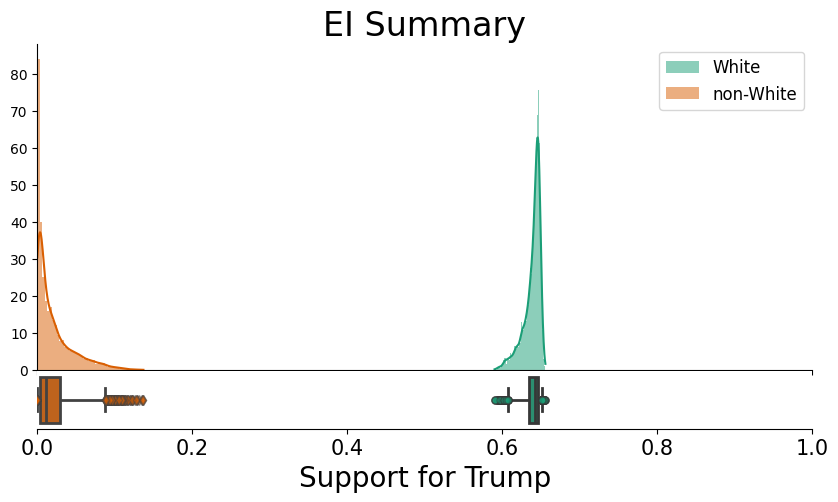

In [546]:
ei_cur_white_g20.plot()
plt.savefig(
    dir_figs.joinpath("ei_g2020_white_trump.png"),
    dpi = 200,
    bbox_inches = "tight"
)

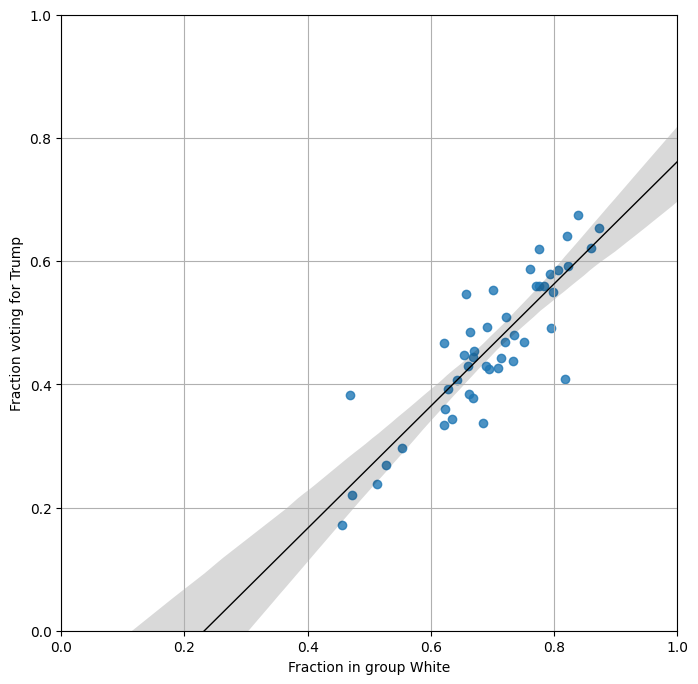

In [550]:
plot = get_goodman_er(
    df_exog_g20, # df_endog_p22_pl94
    "frac_P0030003", # frac_P0030004
    "frac_C20PRERTRU",
    demographic_group_name = "White",
    candidate_name = "Trump",
    fields_complete = ["g20201103_voted_all"],
)


if True:
    plot[0].savefig(
        dir_figs.joinpath("goodman_er_000043_vs_trump_g2020_weighted_by_turnout.png"),
        dpi = 200,
        bbox_inches = "tight",
    )

In [552]:
df_exog_g20.shape

(47, 148)